# Defining the Rates of Supernova Depending on the Environment

This code reads in a "master table' of data from the Open Supernova Catalog [sne.space](https://sne.space/). We make cuts on ra, dec, and redshift to send to classifyenvironments.py from VoidFinder. From there, host galaxy ra and dec are used to make further cuts to be sent to the SDSS Host Survey. The remaining SNe receive their host's Petrosian r-band apparent magnitude that is converted to absolute magnitude. We make the final cut, keeping SNe that are either classified as void or wall and have an absolute magnitude. Rates are determined by comparing number of SNe to number of galaxies in the DR7 footprint.

In [1]:
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, MaskedColumn, QTable, vstack, hstack, join
import astropy.units as u
import astropy.coordinates as coord
from astropy.constants import c as c

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import ks_2samp, anderson_ksamp

### "Master table" is read in. 

Note that this is not all of the SNe in the catalog. We made a cut in Bluehive on 'claimedtype' that were 'Ia', 'Comet', 'LGRB', and 'removed'.

In [2]:
master_table = Table.read('C:/Users/kaeka/Documents/Python/catalog_table_cut1.txt', format = 'ascii.commented_header')

In [3]:
master_table = master_table['ID', 'claimedtype', 'ra', 'dec', 'redshift', 'redshift_kind', 'host', 'hostra', 'hostdec']

In [4]:
# Table length = 48010
# master_table

In [5]:
master_table['claimedtype'].fill_value = '-999'
master_table['redshift_kind'].fill_value = '-999'
master_table['host'].fill_value = '-999'
master_table['ra'].fill_value = -999.
master_table['dec'].fill_value = -999.
master_table['redshift'].fill_value = -999.
master_table['hostra'].fill_value = -999.
master_table['hostdec'].fill_value = -999.

In [6]:
master_table = master_table.filled()

## ClassifyEnvironments.py cuts
(1) Any SNe that does not have a 'claimedtype'
(2) Any SNe that does not have 'ra' or 'dec'
(3) Any SNe that does not have a 'redshift'
(4) Any SNe that has a redshift of 0.

In [7]:
vflag_cut1 = master_table['claimedtype'] != '-999'
master_table_cut = master_table[vflag_cut1]

vflag_cut2 = master_table_cut['ra'] != -999.
master_table_cut = master_table_cut[vflag_cut2]

vflag_cut3 = master_table_cut['redshift'] != -999.
master_table_cut = master_table_cut[vflag_cut3]

vflag_cut4 = master_table_cut['redshift'] != 0.
master_table_cut = master_table_cut[vflag_cut4]

In [8]:
# Table length = 8515
# master_table_cut

In [9]:
input_vflagTable = master_table_cut['ID', 'ra', 'dec', 'redshift']

In [10]:
# input_vflagTable.write('input_vflagTable.txt', format= 'ascii.commented_header', overwrite=True)

### Read in v_flag table from ClassifyEnvironments.py

In [11]:
vflag_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/input_vflagTable_vflag.txt', format= 'ascii.commented_header')

In [12]:
# Table length = 8515
# vflag_table

In [13]:
# Append vflag to "Master Table"

master_table_cut['vflag'] = -999

for i in range(len(vflag_table)):
    SN_ID = vflag_table['ID'][i]
    idx_bool = master_table_cut['ID'] == SN_ID
    master_table_cut['vflag'][idx_bool] = vflag_table['vflag'][i]

In [14]:
# Table length = 8515
# master_table_cut

## SDSS Host Survey cut

(1) Any SNe that does not have 'hostra' and 'hostdec'.

In [15]:
SQL_cut1 = master_table_cut['hostra'] != -999.
master_table_cut = master_table_cut[SQL_cut1]

In [16]:
# Table length = 4757
# master_table_cut

In [17]:
input_sqlTable = master_table_cut['ID', 'hostra', 'hostdec']

In [18]:
# input_sqlTable.write('input_sqlTable.txt', format='ascii.commented_header', overwrite=True)

### Read in r_mag table from SDSS search

In [19]:
rmag_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/SQL_Table_rmag.csv', format= 'ascii.csv')

In [20]:
# Table length = 3465
# rmag_table

In [21]:
master_table_cut['rmag'] = -999.

for i in range(len(rmag_table)):
    gal_ID = rmag_table['ID'][i]
    idx_bool = master_table_cut['ID'] == gal_ID
    master_table_cut['rmag'][idx_bool] = rmag_table['petroMag_r'][i]

In [22]:
# Append vflag and rmag to "Master Table"

master_table['vflag'] = -999
master_table['rmag'] = -999.

for i in range(len(master_table_cut)):
    SN_ID = master_table_cut['ID'][i]
    idx_bool = master_table['ID'] == SN_ID
    master_table['vflag'][idx_bool] = master_table_cut['vflag'][i]

for i in range(len(master_table_cut)):
    gal_ID = master_table_cut['ID'][i]
    idx_bool = master_table['ID'] == gal_ID
    master_table['rmag'][idx_bool] = master_table_cut['rmag'][i]

In [23]:
# master_table

## Function for Absolute Magnitude calculation.
### Note: This still needs to be K-corrected.

In [24]:
# Calculating absolute magnitude.
def abs_mag(m, z, K=0, h=1.):
    """Convert apparent magnitude to absolute magnitude using the distance modulus
    
    M - m = 5 log10(d / 10 pc), where d = cz/H0 (assuming z < 0.1)
    
    Parameters
    ----------
    m : float
        Apparent magnitude; assume r-band.
    z : float
        Redshift.
    K : float
        K-correction.
    h : float
        Dimensionless scaling parameter for Hubble's constant H0.
        
    Returns
    -------
    M : float
        Absolute magnitude (assume r-band).
    """
    H0 = 100 * u.km/u.s/u.Mpc * h
    d = ((c * z) / H0)
    M = m - 5*np.log10(d / (10*u.pc)) - K
    
    return M

In [26]:
master_table['abs_mag'] = abs_mag(master_table['rmag'], master_table['redshift'])

for i in range(len(master_table)):
    no_rmag = master_table['rmag'] == -999.
    master_table['abs_mag'][no_rmag] = -999.

### Check to see if SDSS Host Search missed any hosts.
This is checking all void or wall SNe that have host ra and dec and don't have an rmag.

In [27]:
r_cut2 = master_table['vflag'] != 9
rmag_master_table = master_table[r_cut2]

r_cut3 = rmag_master_table['vflag'] != 2
rmag_master_table = rmag_master_table[r_cut3]

r_cut4 = rmag_master_table['vflag'] != -999
rmag_master_table = rmag_master_table[r_cut4]

In [28]:
check_SDSS = rmag_master_table[rmag_master_table['rmag'] == -999.]

16 entries that have been manually looked up in SDSS DR15 database.

In [30]:
# check_SDSS.show_in_notebook()

In [31]:
check_SDSS[0]['rmag'] = 10.62796
check_SDSS[3]['rmag'] = 14.67315
check_SDSS[5]['rmag'] = 11.77488
check_SDSS[6]['rmag'] = 14.67315
check_SDSS[7]['rmag'] = 10.40886
check_SDSS[8]['rmag'] = 11.77488
check_SDSS[10]['rmag'] = 14.67315
check_SDSS[13]['rmag'] = 14.67315
check_SDSS[14]['rmag'] = 20.14939

In [32]:
# Table length = 16
# check_SDSS

In [33]:
# Append check_SDSS to master_table

for i in range(len(check_SDSS)):
    SN_ID = check_SDSS['ID'][i]
    idx_bool = master_table['ID'] == SN_ID
    master_table['rmag'][idx_bool] = check_SDSS['rmag'][i]

In [34]:
# Run abs_mag function again to fill the 16 SNe missed.
master_table['abs_mag'] = abs_mag(master_table['rmag'], master_table['redshift'])

In [35]:
# master_table.write('COMPLETE_catalog_table_cut1.txt', format='ascii.commented_header', overwrite=True)

## Cuts to master table
(1) cut1 = any host galaxy without rmag value, meaning no host ra or host dec, (2) cut2 = any SN outside of DR7 footprint, (3) cut3 = any SN on edge of DR7 footprint, (4) cut4 = all SN that did not have an ra, dec, and redshift to put into classifyenvironments.py

In [36]:
f_cut1 = master_table['rmag'] != -999.
fcut_master_table = master_table[f_cut1]

f_cut2 = fcut_master_table['vflag'] != 9
fcut_master_table = fcut_master_table[f_cut2]

f_cut3 = fcut_master_table['vflag'] != 2
fcut_master_table = fcut_master_table[f_cut3]

f_cut4 = fcut_master_table['vflag'] != -999
fcut_master_table = fcut_master_table[f_cut4]

In [37]:
# Table length = 672
# fcut_master_table

### looking at 'claimedtype,' there are Ia types listed. This is the first check for Ia to remove it.

In [38]:
Ia_rows, keep_rows, del_rows = [], [], []
for i in range(len(fcut_master_table)):
    Ia_check = fcut_master_table['claimedtype'][i]
    if 'Ia' in Ia_check:
        Ia_rows.append(i)
        split = Ia_check.split(', ')
        for j in range(len(split)):
            if 'Ia' not in split[j]:
                keep_rows.append(i)

for i in range(len(keep_rows)):
    keep_num = keep_rows[i]
    if keep_num in Ia_rows:
        Ia_rows.remove(keep_num)
                
                
            
fcut_master_table.remove_rows(Ia_rows)

In [39]:
# Table length = 575
# fcut_master_table

In [40]:
# fcut_master_table.show_in_notebook()

### Second check for Ia

In [41]:
for i in range(len(fcut_master_table)):
    Ia_check2 = fcut_master_table['claimedtype'][i]
    if 'Ia' in Ia_check2:
        print(i, Ia_check2)

81 Ia, I
83 Ia*, Ia, I
94 Ia, I
99 Ia, I
106 Ia, I
114 Ia, I
119 Ia, I
131 Ia, Ia Pec, I
147 Ia, Ic, Ib/c
156 Ic, Ia
167 Ia-02cx, Ia, II
177 II, Ia
192 Ia, I
224 Ic, Ia
237 Ic, Ia
401 II, Ia, IIb
414 Ia, Ic
457 Ia, II
486 Ia, IIb


In [42]:
fcut_master_table.remove_rows([81, 83, 94, 99, 106, 114, 119, 131, 192])

### Last check for Ia

In [43]:
for i in range(len(fcut_master_table)):
    Ia_check3 = fcut_master_table['claimedtype'][i]
    if 'Ia' in Ia_check3:
        print(i, Ia_check3)

139 Ia, Ic, Ib/c
148 Ic, Ia
159 Ia-02cx, Ia, II
169 II, Ia
215 Ic, Ia
228 Ic, Ia
392 II, Ia, IIb
405 Ia, Ic
448 Ia, II
477 Ia, IIb


In [44]:
# Table length = 566
fcut_master_table

ID,claimedtype,ra,dec,redshift,redshift_kind,host,hostra,hostdec,vflag,rmag,abs_mag
,,,,,,,,,,,
int32,str49,float64,float64,float64,str27,str99,float64,float64,int32,float64,float64
37,II,193.24249999999998,32.41925,0.022805,-999,SDSS J125258.03+322444.3,193.24179166666664,32.412305555555555,0,16.00054,-18.173713897524422
50,II,169.67095833333332,25.166633333333333,0.0254,-999,SDSS J111840.97+250958.5,169.67070833333332,25.166249999999998,0,17.81347,-16.59480209773933
111,"Ib, Ibn",196.0362083333333,52.312916666666666,0.065,-999,SDSS J130408.52+521846.4,196.03549999999998,52.312888888888885,1,20.80107,-15.647600297853916
174,IIn,165.51979166666663,3.500738888888889,0.0348,-999,SDSS J110204.81+033003.1,165.52004166666666,3.500861111111111,0,17.99434,-17.09765973437254
210,Ib,210.5651666666666,33.66119166666667,0.034371,-999,"PGC 2036567, 2MASX J14021617+3339415, 2MASX J14021617+3339",210.56737499999997,33.66152777777778,0,15.92106,-19.14400435370285
212,II,231.34791666666663,29.173472222222223,0.021466,-999,SDSS J152523.40+291018.8,231.34749999999997,29.17188888888889,1,15.69168,-18.35117913976186
220,Ic,234.60541666666663,46.90183333333333,0.043,-999,SDSS J153825.20+465404.1,234.60499999999996,46.90113888888889,1,18.36746,-17.18398579253757
250,IIn,152.0343333333333,19.29982777777778,0.033574,-999,SDSS J100807.76+191758.2,152.0323333333333,19.299500000000002,1,16.64836,-18.365758945103703


In [45]:
# fcut_master_table.write('FINALcut_SNtable.txt', format='ascii.commented_header', overwrite=True)

In [46]:
wall_sn = float(np.sum(fcut_master_table['vflag'] == 0))
void_sn = float(np.sum(fcut_master_table['vflag'] == 1))

print('Wall: ', wall_sn)
print('Void: ', void_sn)

Wall:  249.0
Void:  317.0


## Separating by void/wall and by abs. magnitude
A new table is created, boolean values are made to separte void and wall SNe. A function is used to separate by absolute magnitude.

In [47]:
# -- importing data into an astropy table
sn_table = Table.read('FINALcut_SNtable.txt', format='ascii.commented_header')

In [48]:
### Separating void/wall and magnitude.
vbool = sn_table['vflag'] == 1
wbool = sn_table['vflag'] == 0

v_raDec = fcut_master_table[vbool] # for Mollweide
w_raDec = fcut_master_table[wbool]  # for Mollweide 

v_sn = sn_table[vbool]
w_sn = sn_table[wbool]

# -- magnitude scale is backwards, these are correct
def mag_split(data_table):
   dwbool    = data_table['abs_mag']>-17
   brbool    = data_table['abs_mag']<-20
   bool17_18 = np.logical_and(data_table['abs_mag']<-17,data_table['abs_mag']>-18)
   bool18_19 = np.logical_and(data_table['abs_mag']<-18,data_table['abs_mag']>-19)
   bool19_20 = np.logical_and(data_table['abs_mag']<-19,data_table['abs_mag']>-20)
   bool17_18h = np.logical_and(data_table['abs_mag']<-17,data_table['abs_mag']>-18.5)
   bool18h_20 = np.logical_and(data_table['abs_mag']<-18.5,data_table['abs_mag']>-20)
   faint_bool    = data_table['abs_mag']>-15

   dwarf_table  = data_table[dwbool]
   bright_table = data_table[brbool]
   table17_18   = data_table[bool17_18]
   table18_19   = data_table[bool18_19]
   table19_20   = data_table[bool19_20]
   table17_18h = data_table[bool17_18h]
   table18h_20 = data_table[bool18h_20]
   faint_table = data_table[faint_bool]

   return dwarf_table, bright_table, table17_18, table18_19, table19_20, table17_18h, table18h_20, faint_table

In [49]:
vdwarf_table, vbright_table, v17_18table, v18_19table, v19_20table, v17_18hTable, v18h_20Table, v_faint_table = mag_split(v_sn)

wdwarf_table, wbright_table, wtable17_18, wtable18_19, wtable19_20, wtable17_18h, wtable18h_20, w_faint_table = mag_split(w_sn)

# mag_split(sn_table)

# Histograms

In [50]:
### Making a histogram.
def make_hist(void_input, wall_input, _bins, normalize=False):
    fig, ax = plt.subplots(1, 1)
    
    density = 1 if normalize else None
    
    return (ax.hist(void_input, bins = _bins, color='red', alpha=0.5, density=density, label='void SN'),
            ax.hist(wall_input, bins = _bins, color='black', alpha=0.5, density=density, label='wall SN'),
            ax.legend(), 
            ax.set(xlabel = 'Absolute magnitude, $M_r$',
                   ylabel = 'Count'),
            ax.grid(alpha=0.5))

Text(0.5, 0, 'Absolute Magnitude, $M_r$')

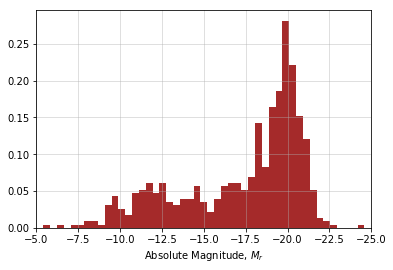

In [51]:
### Plot of 566 SN by all M_r. (normalized)

plt.hist(fcut_master_table['abs_mag'], bins = np.linspace(-25, -5, 50), color='brown', density=1)
plt.xlim(-5,-25)
plt.grid(alpha=0.5)
plt.xlabel('Absolute Magnitude, $M_r$')

Ks_2sampResult(statistic=0.17245005257623552, pvalue=0.00041627240350696057)


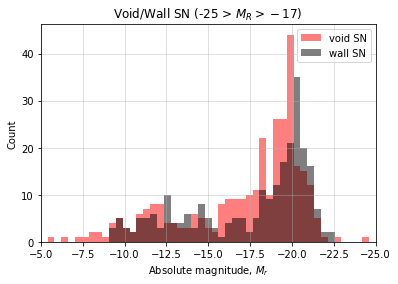

In [52]:
### Histogram of SN separated into void and wall of all M_r.
make_hist(v_sn['abs_mag'], w_sn['abs_mag'], np.linspace(-25, -5, 50))# , normalize=True)
plt.xlim(-5,-25)
plt.title('Void/Wall SN (-25 > $M_R > -17$)')
print(ks_2samp(v_sn['abs_mag'], w_sn['abs_mag']))

Ks_2sampResult(statistic=0.1275967520826743, pvalue=0.3860522286219478)
N_wall = 87
N_void = 109


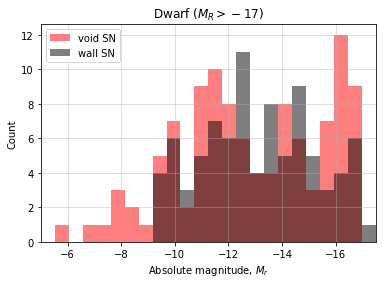

In [53]:
### DWARF ( > -17)
make_hist(vdwarf_table['abs_mag'], wdwarf_table['abs_mag'], np.linspace(-17.5, -5, 25))
plt.xlim(-5,-17.5)
plt.title('Dwarf ($M_R > -17$)')
print(ks_2samp(vdwarf_table['abs_mag'], wdwarf_table['abs_mag']))
print('N_wall = {:d}'.format(len(wdwarf_table['abs_mag'])))
print('N_void = {:d}'.format(len(vdwarf_table['abs_mag'])))

Ks_2sampResult(statistic=0.14529914529914534, pvalue=0.9972611413995305)
N_wall = 9
N_void = 26


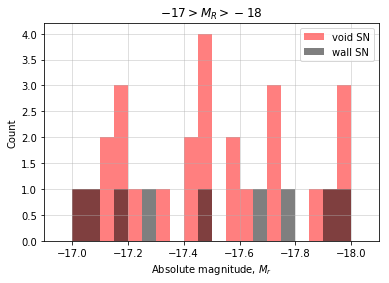

In [54]:
### 17-18
make_hist(v17_18table['abs_mag'], wtable17_18['abs_mag'], np.linspace(-18.1, -16.9, 25))
plt.xlim(-16.9,-18.1)
plt.title('$-17 > M_R > -18$')
print(ks_2samp(v17_18table['abs_mag'], wtable17_18['abs_mag']))
print('N_wall = {:d}'.format(len(wtable17_18['abs_mag'])))
print('N_void = {:d}'.format(len(v17_18table['abs_mag'])))

Ks_2sampResult(statistic=0.24637681159420288, pvalue=0.2615585188587854)
N_wall = 23
N_void = 48


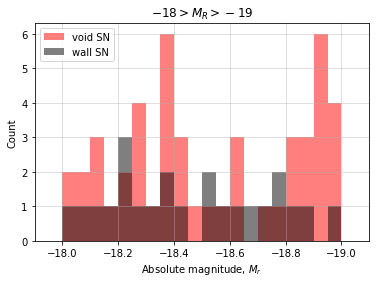

In [55]:
### 18-19
make_hist(v18_19table['abs_mag'], wtable18_19['abs_mag'], np.linspace(-19.1, -17.9, 25))
plt.xlim(-17.9,-19.1)
plt.title('$-18 > M_R > -19$')
print(ks_2samp(v18_19table['abs_mag'], wtable18_19['abs_mag']))
print('N_wall = {:d}'.format(len(wtable18_19['abs_mag'])))
print('N_void = {:d}'.format(len(v18_19table['abs_mag'])))

Ks_2sampResult(statistic=0.18410852713178297, pvalue=0.2906268103516748)
N_wall = 43
N_void = 72


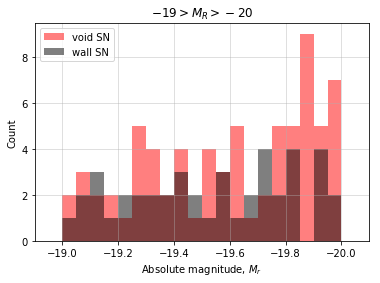

In [56]:
### 19-20
make_hist(v19_20table['abs_mag'], wtable19_20['abs_mag'], np.linspace(-20.1, -18.9, 25))
plt.xlim(-18.9,-20.1)
plt.title('$-19 > M_R > -20$')
print(ks_2samp(v19_20table['abs_mag'], wtable19_20['abs_mag']))
print('N_wall = {:d}'.format(len(wtable19_20['abs_mag'])))
print('N_void = {:d}'.format(len(v19_20table['abs_mag'])))

Ks_2sampResult(statistic=0.16407119021134597, pvalue=0.2595754729276525)
N_wall = 87
N_void = 62


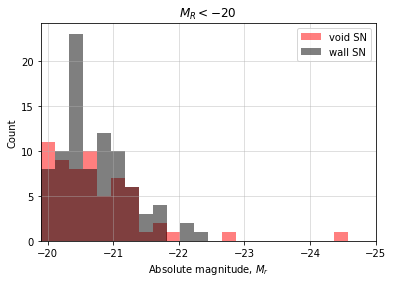

In [57]:
### BRIGHT (< -20)
make_hist(vbright_table['abs_mag'], wbright_table['abs_mag'], np.linspace(-25, -19.9, 25))
plt.xlim(-19.9,-25)
plt.title('$M_R < -20$')
print(ks_2samp(vbright_table['abs_mag'], wbright_table['abs_mag']))
print('N_wall = {:d}'.format(len(wbright_table['abs_mag'])))
print('N_void = {:d}'.format(len(vbright_table['abs_mag'])))

Ks_2sampResult(statistic=0.12885154061624654, pvalue=0.952708777938529)
N_wall = 21
N_void = 51


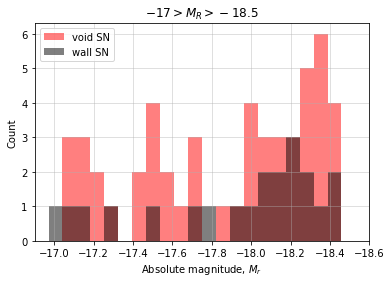

In [58]:
### 17-18.5

make_hist(v17_18hTable['abs_mag'], wtable17_18h['abs_mag'], np.linspace(-18.6, -16.9, 25))
plt.xlim(-16.9,-18.6)
plt.title('$-17 > M_R > -18.5$')
print(ks_2samp(v17_18hTable['abs_mag'], wtable17_18h['abs_mag']))
print('N_wall = {:d}'.format(len(wtable17_18h['abs_mag'])))
print('N_void = {:d}'.format(len(v17_18hTable['abs_mag'])))

Ks_2sampResult(statistic=0.13060428849902533, pvalue=0.569614780500535)
N_wall = 54
N_void = 95


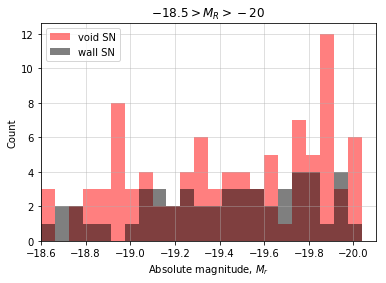

In [59]:
### 18.5-20

make_hist(v18h_20Table['abs_mag'], wtable18h_20['abs_mag'], np.linspace(-20.1, -18.6, 25))
plt.xlim(-18.6,-20.1)
plt.title('$-18.5 > M_R > -20$')
print(ks_2samp(v18h_20Table['abs_mag'], wtable18h_20['abs_mag']))
print('N_wall = {:d}'.format(len(wtable18h_20['abs_mag'])))
print('N_void = {:d}'.format(len(v18h_20Table['abs_mag'])))

## Diagnostic Plots

Mollweide projection of SN ra and dec. Redshift histogram. (RA hist and dec hist for hosts?)

In [61]:
mw_table = fcut_master_table['ra', 'dec']
# mw_table.write('mollweide_coords.txt', format='ascii.commented_header')

In [62]:
ra = coord.Angle(fcut_master_table['ra'] * u.degree)
dec = coord.Angle(fcut_master_table['dec'] * u.degree)
ra = ra.wrap_at(180*u.degree)

# v_ra = coord.Angle(v_raDec['ra'] * u.degree)
# w_ra = coord.Angle(w_raDec['ra'] * u.degree)
# v_ra = ra.wrap_at(180*u.degree)
# w_ra = ra.wrap_at(180*u.degree)
# v_dec = coord.Angle(v_raDec['dec'] * u.degree)
# w_dec = coord.Angle(w_raDec['dec'] * u.degree)
# v_dec = dec.wrap_at(180*u.degree)
# w_dec = dec.wrap_at(180*u.degree)

# print(len(v_raDec['ra']), len(w_raDec['ra']), len(v_raDec['dec']), len(w_raDec['dec']))
# print(len(v_ra), len(w_ra), len(v_dec), len(w_dec))

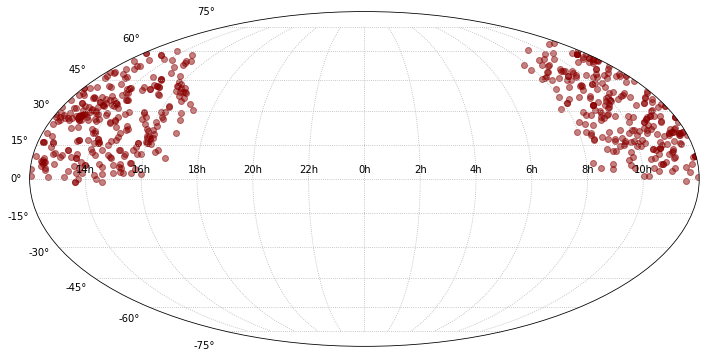

In [63]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(ra.radian, dec.radian, color='darkred', alpha=0.5)
# ax.scatter(v_ra.radian, v_dec.radian, color='red', alpha=0.4)
# ax.scatter(w_ra.radian, w_dec.radian, color='black', alpha=0.4)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(ls=':')

Text(0, 0.5, 'Dec')

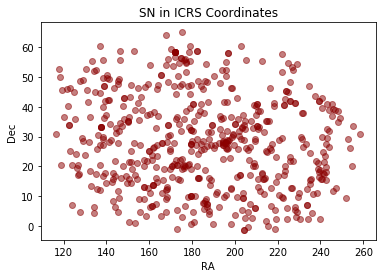

In [64]:
plt.scatter(fcut_master_table['ra'], fcut_master_table['dec'], color='darkred', alpha = 0.5)
plt.title('SN in ICRS Coordinates')
plt.xlabel('RA')
plt.ylabel('Dec')

Text(0.5, 0, 'Redshift, z')

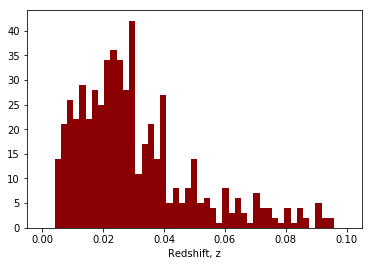

In [65]:
plt.hist(fcut_master_table['redshift'], bins=np.linspace(0.0, 0.1, 50), color='darkred')
plt.xlabel('Redshift, z')

### Number of SN in each category:

In [66]:
void_sn = float(np.sum(v_sn['vflag'] == 1))
wall_sn = float(np.sum(w_sn['vflag'] == 0))

vDwarf_sn = float(np.sum(vdwarf_table['vflag'] == 1))
wDwarf_sn = float(np.sum(wdwarf_table['vflag'] == 0))

v1718_sn = float(np.sum(v17_18table['vflag'] == 1))
w1718_sn = float(np.sum(wtable17_18['vflag'] == 0))

v1819_sn = float(np.sum(v18_19table['vflag'] == 1))
w1819_sn = float(np.sum(wtable18_19['vflag'] == 0))

v1920_sn = float(np.sum(v19_20table['vflag'] == 1))
w1920_sn = float(np.sum(wtable19_20['vflag'] == 0))

vBright_sn = float(np.sum(vbright_table['vflag'] == 1))
wBright_sn = float(np.sum(wbright_table['vflag'] == 0))

v1718h_sn = float(np.sum(v17_18hTable['vflag'] == 1))
w1718h_sn = float(np.sum(wtable17_18h['vflag'] == 0))

v18h20_sn = float(np.sum(v18h_20Table['vflag'] == 1))
w18h20_sn = float(np.sum(wtable18h_20['vflag'] == 0))

print(void_sn, wall_sn, vDwarf_sn, wDwarf_sn, v1718_sn, w1718_sn, v1819_sn, w1819_sn, v1920_sn, w1920_sn, 
      vBright_sn, wBright_sn, v1718h_sn, w1718h_sn, v18h20_sn, w18h20_sn)

317.0 249.0 109.0 87.0 26.0 9.0 48.0 23.0 72.0 43.0 62.0 87.0 51.0 21.0 95.0 54.0


### Number of Galaxies in each catagory:

In [67]:
void_gal = 75254.
wall_gal = 620555.

vDwarf_gal = 2942.
wDwarf_gal = 3681.

v1718_gal = 3894.
w1718_gal = 9769.

v1819_gal = 8932.
w1819_gal = 21161.

v1920_gal = 8167.
w1920_gal = 20279.

vBright_gal = 51319.
wBright_gal = 565665.

v1718h_gal = 7781
w1718h_gal = 19119

v18h20_gal = 13212
w18h20_gal = 32090

print(void_gal, wall_gal, vDwarf_gal, wDwarf_gal, v1718_gal, w1718_gal, v1819_gal, w1819_gal, v1920_gal, w1920_gal, 
      vBright_gal, wBright_gal, v1718h_gal, w1718h_gal, v18h20_gal, w18h20_gal)

75254.0 620555.0 2942.0 3681.0 3894.0 9769.0 8932.0 21161.0 8167.0 20279.0 51319.0 565665.0 7781 19119 13212 32090


### Rates of finding SNe in a specific environment, depending on absolute magnitude.

In [68]:
void_rate = void_sn/void_gal
wall_rate =  wall_sn/wall_gal

vDwarf_rate = vDwarf_sn/vDwarf_gal
wDwarf_rate = wDwarf_sn/wDwarf_gal

v1718_rate = v1718_sn/v1718_gal
w1718_rate = w1718_sn/w1718_gal

v1819_rate = v1819_sn/v1819_gal
w1819_rate = w1819_sn/w1819_gal

v1920_rate = v1920_sn/v1920_gal
w1920_rate = w1920_sn/w1920_gal

vBright_rate = vBright_sn/vBright_gal
wBright_rate = wBright_sn/wBright_gal

v1718h_rate = v1718h_sn/v1718h_gal
w1718h_rate = w1718h_sn/w1718h_gal

v18h20_rate = v18h20_sn/v18h20_gal
w18h20_rate = w18h20_sn/w18h20_gal

# Rates:

In [69]:
print('Void SN Rate: ', void_rate)
print('Wall SN Rate: ', wall_rate)
print('-------------------------------------')
print('Dwarf Void SN Rate: ', vDwarf_rate)
print('Dwarf Wall SN Rate: ', wDwarf_rate)
print('-------------------------------------')
print('17-18 Void SN Rate: ', v1718_rate)
print('17-18 Wall SN Rate: ', w1718_rate)
print('-------------------------------------')
print('17-18h Void SN Rate: ', v1718h_rate)
print('17-18h Wall SN Rate: ', w1718h_rate)
print('-------------------------------------')
print('18-19 Void SN Rate: ', v1819_rate)
print('18-19 Wall SN Rate: ', w1819_rate)
print('-------------------------------------')
print('18h-20 Void SN Rate: ', v18h20_rate)
print('18h-20 Wall SN Rate: ', w18h20_rate)
print('-------------------------------------')
print('19-20 Void SN Rate: ', v1920_rate)
print('19-20 Wall SN Rate: ', w1920_rate)
print('-------------------------------------')
print('Bright Void SN Rate: ', vBright_rate)
print('Bright Wall SN Rate: ', wBright_rate)

Void SN Rate:  0.004212400669731842
Wall SN Rate:  0.0004012537164312591
-------------------------------------
Dwarf Void SN Rate:  0.03704962610469069
Dwarf Wall SN Rate:  0.023634881825590873
-------------------------------------
17-18 Void SN Rate:  0.00667693888032871
17-18 Wall SN Rate:  0.0009212816050772853
-------------------------------------
17-18h Void SN Rate:  0.006554427451484385
17-18h Wall SN Rate:  0.00109838380668445
-------------------------------------
18-19 Void SN Rate:  0.005373936408419167
18-19 Wall SN Rate:  0.0010869051557109777
-------------------------------------
18h-20 Void SN Rate:  0.007190432939751741
18h-20 Wall SN Rate:  0.0016827672172016203
-------------------------------------
19-20 Void SN Rate:  0.008815966695236929
19-20 Wall SN Rate:  0.0021204201390601115
-------------------------------------
Bright Void SN Rate:  0.0012081295426645102
Bright Wall SN Rate:  0.00015380127814165629


## KS Two-Sample Test: 

In [70]:
print('KS Test for ALL Void/Wall:      ', ks_2samp(v_sn['abs_mag'], w_sn['abs_mag']))
print('KS Test for Dwarf Void/Wall:    ', ks_2samp(vdwarf_table['abs_mag'], wdwarf_table['abs_mag']))
print('KS Test for 17-18 Void/Wall:    ', ks_2samp(v17_18table['abs_mag'], wtable17_18['abs_mag']))
print('KS Test for 17-18.5 Void/Wall:  ', ks_2samp(v17_18hTable['abs_mag'], wtable17_18h['abs_mag']))
print('KS Test for 18-19 Void/Wall:    ', ks_2samp(v18_19table['abs_mag'], wtable18_19['abs_mag']))
print('KS Test for 18.5-20 Void/Wall:  ', ks_2samp(v18h_20Table['abs_mag'], wtable18h_20['abs_mag']))
print('KS Test for 19-20 Void/Wall:    ', ks_2samp(v19_20table['abs_mag'], wtable19_20['abs_mag']))
print('KS Test for Bright Void/Wall:   ', ks_2samp(vbright_table['abs_mag'], wbright_table['abs_mag']))

KS Test for ALL Void/Wall:       Ks_2sampResult(statistic=0.17245005257623552, pvalue=0.00041627240350696057)
KS Test for Dwarf Void/Wall:     Ks_2sampResult(statistic=0.1275967520826743, pvalue=0.3860522286219478)
KS Test for 17-18 Void/Wall:     Ks_2sampResult(statistic=0.14529914529914534, pvalue=0.9972611413995305)
KS Test for 17-18.5 Void/Wall:   Ks_2sampResult(statistic=0.12885154061624654, pvalue=0.952708777938529)
KS Test for 18-19 Void/Wall:     Ks_2sampResult(statistic=0.24637681159420288, pvalue=0.2615585188587854)
KS Test for 18.5-20 Void/Wall:   Ks_2sampResult(statistic=0.13060428849902533, pvalue=0.569614780500535)
KS Test for 19-20 Void/Wall:     Ks_2sampResult(statistic=0.18410852713178297, pvalue=0.2906268103516748)
KS Test for Bright Void/Wall:    Ks_2sampResult(statistic=0.16407119021134597, pvalue=0.2595754729276525)


## AD k-sample Test:

In [71]:
print('AD Test for ALL Void/Wall:     ', anderson_ksamp([v_sn['abs_mag'], w_sn['abs_mag']]))
print(' ')
print('AD Test for Dwarf Void/Wall:   ', anderson_ksamp([vdwarf_table['abs_mag'], wdwarf_table['abs_mag']]))
print(' ')
print('AD Test for 17-18 Void/Wall:   ', anderson_ksamp([v17_18table['abs_mag'], wtable17_18['abs_mag']]))
print(' ')
print('AD Test for 17-18.5 Void/Wall: ', anderson_ksamp([v17_18hTable['abs_mag'], wtable17_18h['abs_mag']]))
print(' ')
print('AD Test for 18-19 Void/Wall:   ', anderson_ksamp([v18_19table['abs_mag'], wtable18_19['abs_mag']]))
print(' ')
print('AD Test for 18.5-20 Void/Wall: ', anderson_ksamp([v18h_20Table['abs_mag'], wtable18h_20['abs_mag']]))
print(' ')
print('AD Test for 19-20 Void/Wall:   ', anderson_ksamp([v19_20table['abs_mag'], wtable19_20['abs_mag']]))
print(' ')
print('AD Test for Bright Void/Wall:  ', anderson_ksamp([vbright_table['abs_mag'], wbright_table['abs_mag']]))

AD Test for ALL Void/Wall:      Anderson_ksampResult(statistic=5.255001862757036, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.002958358147291843)
 
AD Test for Dwarf Void/Wall:    Anderson_ksampResult(statistic=0.6033257762167769, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.18757499233989416)
 
AD Test for 17-18 Void/Wall:    Anderson_ksampResult(statistic=-0.7830486622134024, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.7984296243570326)
 
AD Test for 17-18.5 Void/Wall:  Anderson_ksampResult(statistic=-0.9659346886586735, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.9735836290954042)
 
AD Test for 18-19 Void/Wall:    Anderson_ksampResult(statistic=-0.24870708730874197, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.4516269361458121)
 
AD Test for 18.5-20 Void/Wall:  Anderson_ksampResult(statistic=-0.34787481

C:\Users\kaeka\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1680: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Text(0, 0.5, 'Redshift, z')

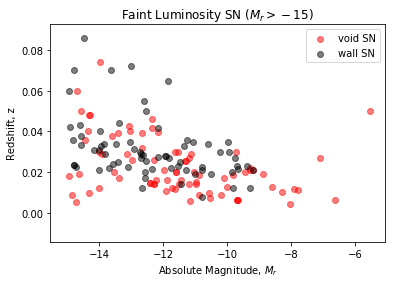

In [72]:
plt.scatter(v_faint_table['abs_mag'], v_faint_table['redshift'], color='red', alpha = 0.5, label='void SN')
plt.scatter(w_faint_table['abs_mag'], w_faint_table['redshift'], color='black', alpha = 0.5, label='wall SN')
plt.legend()
plt.title('Faint Luminosity SN ($M_r > -15$)')
plt.xlabel('Absolute Magnitude, $M_r$')
plt.ylabel('Redshift, z')

# Spec vs. Photo

## Photometric

In [79]:
photo_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/PhotoObj_petroMags_compare.csv', format='ascii.csv')

In [80]:
photo_table

ID,PhotoObjID,hostra,hostdec,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
50405,1237645943978394148,55.17916,1.003056,55.1812195005073,1.00452552639352,24.90069,22.98524,21.9845,22.01487,21.69403,2.5657,0.3465801,0.2322551,0.3171721,0.8836965,0.4059806,0.3163373,0.2188407,0.1626221,0.120961
42620,1237645943979245809,57.072,0.979119,57.0718989746965,0.97912262719482,23.11853,22.43439,20.67638,20.18196,19.80256,1.420907,0.3968346,0.1339378,0.1214537,0.2732925,0.8628602,0.6723348,0.4651181,0.3456326,0.2570872
52624,1237646586636337484,80.74583,-0.1405556,80.7462249611808,-0.140522526243688,16.85794,14.75322,13.84405,13.36351,12.99879,0.05620049,0.03478524,0.03234785,0.03071933,0.02737458,0.6443334,0.5020602,0.3473229,0.2580982,0.1919776
50137,1237648673971437623,189.522,-0.027,189.522249247665,-0.0270313533159909,16.07241,14.63305,13.87436,13.46286,13.12094,0.02221921,0.01184188,0.005256547,0.008665761,0.01702027,0.1079738,0.08413248,0.05820246,0.04325067,0.03217055
49617,1237648702972625038,197.421,-1.0483,197.421173999056,-1.04825957679716,17.12403,15.66151,14.98679,14.66293,14.45834,0.07095927,0.01059596,0.008025119,0.01088241,0.03674904,0.1221101,0.09514735,0.0658225,0.04891317,0.03638241
1584,1237648702975639736,204.3881,-1.239694,204.388107219911,-1.23971643263818,19.66991,18.21419,17.40083,16.8949,16.69452,0.1593816,0.02166022,0.02142881,0.0291203,0.06107592,0.1162125,0.09055199,0.06264345,0.04655079,0.03462524
48768,1237648702977343535,208.225,-1.114444,208.22692216751,-1.11461202391513,13.72815,12.60217,12.13714,11.72745,11.72094,0.008498966,0.006133866,0.006247961,0.007491839,0.01084408,0.1952974,0.1521744,0.1052736,0.07822953,0.0581884
51794,1237648702979113571,212.3125,-1.181667,212.313067247632,-1.18184139087215,25.7044,23.07996,21.07204,21.5801,21.10277,3.877271,1.549309,0.1991421,1.109688,1.830276,0.2268893,0.1767906,0.1223029,0.09088418,0.06760113
471,1237648702981931189,218.7242,-1.137167,218.724254604722,-1.13717654814687,18.21297,17.07721,16.66503,16.40978,16.35763,0.04589402,0.008631161,0.008815694,0.01057955,0.03765701,0.1658757,0.1292492,0.089414,0.06644418,0.04942227


In [81]:
### Append fcut_master_table

# photo_table['claimedtype'] = '-999'
photo_table['ra'] = -999.
photo_table['dec'] = -999.
photo_table['redshift'] = -999.
# photo_table['redshift_kind'] = '-999'
# photo_table['host'] = '-999'
photo_table['vflag'] = -9
photo_table['OLD_rmag'] = -999.
photo_table['OLD_abs_mag'] = -999.


for i in range(len(fcut_master_table)):
    SN_ID = fcut_master_table['ID'][i]
    idx_bool = photo_table['ID'] == SN_ID
#     photo_table['claimedtype'][idx_bool] = fcut_master_table['claimedtype'][i]
    photo_table['ra'][idx_bool] = fcut_master_table['ra'][i]
    photo_table['dec'][idx_bool] = fcut_master_table['dec'][i]
    photo_table['redshift'][idx_bool] = fcut_master_table['redshift'][i]
#     photo_table['redshift_kind'][idx_bool] = fcut_master_table['redshift_kind'][i]
#     photo_table['host'][idx_bool] = fcut_master_table['host'][i]
    photo_table['vflag'][idx_bool] = fcut_master_table['vflag'][i]
    photo_table['OLD_rmag'][idx_bool] = fcut_master_table['rmag'][i]
    photo_table['OLD_abs_mag'][idx_bool] = fcut_master_table['abs_mag'][i]

## Spectroscopic

In [82]:
spec_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/SpecObj_petroMags_compare.csv', format='ascii.csv')

In [83]:
null_rows, nonNull_rows = [], []
for i in range(len(spec_table)):
    null_check = spec_table['photoObjID'][i]
    if 'null' in null_check:
        null_rows.append(i)
    else:
        nonNull_rows.append(i)
                
                
spec_table.remove_rows(null_rows)

In [84]:
### Append fcut_master_table

# photo_table['claimedtype'] = '-999'
spec_table['ra'] = -999.
spec_table['dec'] = -999.
spec_table['redshift'] = -999.
# spec_table['redshift_kind'] = '-999'
# spec_table['host'] = '-999'
spec_table['vflag'] = -9
spec_table['OLD_rmag'] = -999.
spec_table['OLD_abs_mag'] = -999.


for i in range(len(fcut_master_table)):
    SN_ID = fcut_master_table['ID'][i]
    idx_bool = spec_table['ID'] == SN_ID
#     spec_table['claimedtype'][idx_bool] = fcut_master_table['claimedtype'][i]
    spec_table['ra'][idx_bool] = fcut_master_table['ra'][i]
    spec_table['dec'][idx_bool] = fcut_master_table['dec'][i]
    spec_table['redshift'][idx_bool] = fcut_master_table['redshift'][i]
#     spec_table['redshift_kind'][idx_bool] = fcut_master_table['redshift_kind'][i]
#     spec_table['host'][idx_bool] = fcut_master_table['host'][i]
    spec_table['vflag'][idx_bool] = fcut_master_table['vflag'][i]
    spec_table['OLD_rmag'][idx_bool] = fcut_master_table['rmag'][i]
    spec_table['OLD_abs_mag'][idx_bool] = fcut_master_table['abs_mag'][i]

In [85]:
# spec_table

## Calculating abs. mag (without K-correction) based on petroMag_r

### Photometric

In [86]:
photo_table['abs_mag'] = abs_mag(photo_table['petroMag_r'], photo_table['redshift'])

In [87]:
photo_table

ID,PhotoObjID,hostra,hostdec,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,ra,dec,redshift,vflag,OLD_rmag,OLD_abs_mag,abs_mag
,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64
50405,1237645943978394148,55.17916,1.003056,55.1812195005073,1.00452552639352,24.90069,22.98524,21.9845,22.01487,21.69403,2.5657,0.3465801,0.2322551,0.3171721,0.8836965,0.4059806,0.3163373,0.2188407,0.1626221,0.120961,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan
42620,1237645943979245809,57.072,0.979119,57.0718989746965,0.97912262719482,23.11853,22.43439,20.67638,20.18196,19.80256,1.420907,0.3968346,0.1339378,0.1214537,0.2732925,0.8628602,0.6723348,0.4651181,0.3456326,0.2570872,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan
52624,1237646586636337484,80.74583,-0.1405556,80.7462249611808,-0.140522526243688,16.85794,14.75322,13.84405,13.36351,12.99879,0.05620049,0.03478524,0.03234785,0.03071933,0.02737458,0.6443334,0.5020602,0.3473229,0.2580982,0.1919776,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan
50137,1237648673971437623,189.522,-0.027,189.522249247665,-0.0270313533159909,16.07241,14.63305,13.87436,13.46286,13.12094,0.02221921,0.01184188,0.005256547,0.008665761,0.01702027,0.1079738,0.08413248,0.05820246,0.04325067,0.03217055,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan
49617,1237648702972625038,197.421,-1.0483,197.421173999056,-1.04825957679716,17.12403,15.66151,14.98679,14.66293,14.45834,0.07095927,0.01059596,0.008025119,0.01088241,0.03674904,0.1221101,0.09514735,0.0658225,0.04891317,0.03638241,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan
1584,1237648702975639736,204.3881,-1.239694,204.388107219911,-1.23971643263818,19.66991,18.21419,17.40083,16.8949,16.69452,0.1593816,0.02166022,0.02142881,0.0291203,0.06107592,0.1162125,0.09055199,0.06264345,0.04655079,0.03462524,204.38844999999998,-1.2396805555555557,0.08,0,17.40083,-19.498723449599353,-19.498723449599353
48768,1237648702977343535,208.225,-1.114444,208.22692216751,-1.11461202391513,13.72815,12.60217,12.13714,11.72745,11.72094,0.008498966,0.006133866,0.006247961,0.007491839,0.01084408,0.1952974,0.1521744,0.1052736,0.07822953,0.0581884,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan
51794,1237648702979113571,212.3125,-1.181667,212.313067247632,-1.18184139087215,25.7044,23.07996,21.07204,21.5801,21.10277,3.877271,1.549309,0.1991421,1.109688,1.830276,0.2268893,0.1767906,0.1223029,0.09088418,0.06760113,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan


In [88]:
p_cut1 = photo_table['ra'] != -999.
pcut1_photo_table = photo_table[p_cut1]

In [89]:
# pcut1_photo_table

### Spectroscopic

In [90]:
spec_table['petroMag_r'] = spec_table['petroMag_r'].astype(float)
    
spec_table['abs_mag'] = abs_mag(spec_table['petroMag_r'], spec_table['redshift'])

In [91]:
spec_table

ID,SpecObjID,photoObjID,hostra,hostdec,SDSSra,SDSSdec,SDSSredshift,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,ra,dec,redshift,vflag,OLD_rmag,OLD_abs_mag,abs_mag
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,str19,str19,float64,float64,float64,float64,float64,str8,str8,float64,str8,str8,str11,str11,str11,str11,str11,str10,str10,str10,str10,str11,float64,float64,float64,int32,float64,float64,float64
47914,1012215121411336192,1237657633260699874,138.7333,46.90333,138.73198,46.903084,0.01418223,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,138.7297916666666,46.900555555555556,0.014,1,20.84762,-12.267123693030832,-19.796023693030833
46384,1012215121411336192,1237657633260699874,138.7333,46.90333,138.73198,46.903084,0.01418223,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,138.73749999999995,46.906666666666666,0.014,1,20.84762,-12.267123693030832,-19.796023693030833
53292,1009964695735527424,1237657770704437449,134.748,44.83058,134.74805,44.830595,0.04789706,18.53933,17.36878,17.02961,16.75984,16.67812,0.06435547,0.0104827,0.010886,0.01702177,0.05874692,0.08809423,0.06864243,0.04748652,0.03528757,0.02624747,134.74907499999998,44.83121666666667,0.0479,1,17.02961,-18.756171081712456,-18.756171081712456
48315,1001088614215477248,1237657594072399953,117.5,30.025,117.5001,30.02495,0.0275748,16.25987,14.57942,13.77483,13.3539,13.12543,0.025708,0.003979345,0.002559836,0.002533771,0.005715167,0.2180092,0.1698713,0.1175162,0.08732712,0.06495534,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan
52803,1001045733261993984,1237657608030454182,116.3624,29.89067,116.36421,29.890351,0.02373924,18.37527,17.66226,17.21834,17.06759,17.33457,0.08279999,0.02831298,0.01366833,0.02455415,0.1211019,0.1849732,0.1441299,0.09970839,0.07409402,0.05511234,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan
52674,1001027591320135680,1237657595683078624,116.4302,31.00856,116.43021,31.008608,0.06210726,18.90909,17.30345,16.38588,15.88615,15.56561,0.1297515,0.02598192,0.02386489,0.01760161,0.01793127,0.2383671,0.185734,0.1284899,0.09548178,0.0710209,116.43066666666665,31.007722222222224,0.062,0,16.38588,-19.96018196213091,-19.96018196213091
52852,960493540557744128,1237671991339516005,203.3631,5.482555,203.36689,5.4803297,0.02222189,16.79994,15.26885,14.77735,14.57,14.43348,0.04758821,0.008153033,0.006066226,0.006944962,0.02623263,0.1415546,0.1102984,0.0763039,0.05670198,0.04217585,203.36333333333332,5.482727777777778,0.022,0,22.33684,-11.759376918750672,-19.318866918750672
48974,960432792540309504,1237671957517828103,204.372,4.1044,204.37236,4.1044168,0.02305833,16.1986,14.40249,13.71841,13.37577,13.39722,0.03148549,0.01532795,0.01465714,0.01350829,0.01408836,0.1074442,0.0837198,0.05791697,0.04303851,0.03201275,-999.0,-999.0,-999.0,-9,-999.0,-999.0,nan


In [92]:
s_cut1 = spec_table['ra'] != -999.
scut_spec_table = spec_table[s_cut1]

In [93]:
scut_spec_table

ID,SpecObjID,photoObjID,hostra,hostdec,SDSSra,SDSSdec,SDSSredshift,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,ra,dec,redshift,vflag,OLD_rmag,OLD_abs_mag,abs_mag
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,str19,str19,float64,float64,float64,float64,float64,str8,str8,float64,str8,str8,str11,str11,str11,str11,str11,str10,str10,str10,str10,str11,float64,float64,float64,int32,float64,float64,float64
47914,1012215121411336192,1237657633260699874,138.7333,46.90333,138.73198,46.903084,0.01418223,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,138.7297916666666,46.900555555555556,0.014,1,20.84762,-12.267123693030832,-19.796023693030833
46384,1012215121411336192,1237657633260699874,138.7333,46.90333,138.73198,46.903084,0.01418223,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,138.73749999999995,46.906666666666666,0.014,1,20.84762,-12.267123693030832,-19.796023693030833
53292,1009964695735527424,1237657770704437449,134.748,44.83058,134.74805,44.830595,0.04789706,18.53933,17.36878,17.02961,16.75984,16.67812,0.06435547,0.0104827,0.010886,0.01702177,0.05874692,0.08809423,0.06864243,0.04748652,0.03528757,0.02624747,134.74907499999998,44.83121666666667,0.0479,1,17.02961,-18.756171081712456,-18.756171081712456
52674,1001027591320135680,1237657595683078624,116.4302,31.00856,116.43021,31.008608,0.06210726,18.90909,17.30345,16.38588,15.88615,15.56561,0.1297515,0.02598192,0.02386489,0.01760161,0.01793127,0.2383671,0.185734,0.1284899,0.09548178,0.0710209,116.43066666666665,31.007722222222224,0.062,0,16.38588,-19.96018196213091,-19.96018196213091
52852,960493540557744128,1237671991339516005,203.3631,5.482555,203.36689,5.4803297,0.02222189,16.79994,15.26885,14.77735,14.57,14.43348,0.04758821,0.008153033,0.006066226,0.006944962,0.02623263,0.1415546,0.1102984,0.0763039,0.05670198,0.04217585,203.36333333333332,5.482727777777778,0.022,0,22.33684,-11.759376918750672,-19.318866918750672
46778,951452806315796480,1237655123937001520,187.92,3.9263,187.92039,3.9263188,0.01510862,15.19202,13.76654,13.19738,12.94468,12.71065,0.05233434,0.09054002,0.09245452,0.09400122,0.08461305,0.1044479,0.08138506,0.05630181,0.04183828,0.03111999,187.92041666666665,3.9230555555555555,0.01511,1,13.19738,-20.08304583633476,-20.08304583633476
54551,951435214129752064,1237668675623518317,188.1225,4.88875,188.12247,4.8887827,0.08277824,19.00992,17.83483,17.33247,17.01103,16.94851,0.09887942,0.01423734,0.009916445,0.01776873,0.07012024,0.08521064,0.06639556,0.04593214,0.0341325,0.02538831,188.1222833333333,4.888958333333333,0.082797,0,17.33247,-19.641706520602128,-19.641706520602128
56169,946911823192418304,1237654604797837662,180.6513,4.549917,180.65136,4.5499441,0.0189063,19.34829,17.69456,17.28776,17.13502,17.50963,0.1859046,0.02162987,0.02153032,0.02644706,0.1317954,0.08013414,0.06243998,0.04319569,0.03209903,0.02387578,180.65099999999998,4.549888888888889,0.018848,1,17.28776,-16.472669880174678,-16.472669880174678


## Photo v. Spec Histograms

In [94]:
def make_compHist(_input, _bins, _label, normalize=False):
    fig, ax = plt.subplots(1, 1)
    
    density = 1 if normalize else None
    
    return (ax.hist(_input, bins = _bins, color='darkred', density=density, label= _label),
            ax.legend(), 
            ax.set(xlabel = 'Absolute magnitude, $M_r$',
                   ylabel = 'Count'),
            ax.grid(alpha=0.5))

(-5, -25)

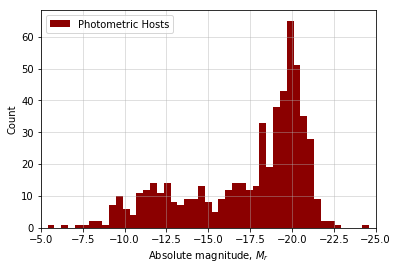

In [95]:
make_compHist(pcut1_photo_table['abs_mag'], np.linspace(-25, -5, 50), 'Photometric Hosts')
plt.xlim(-5,-25)

(-5, -25)

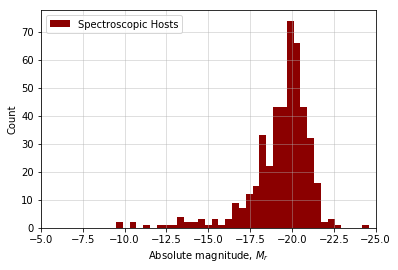

In [96]:
make_compHist(scut_spec_table['abs_mag'], np.linspace(-25, -5, 50), 'Spectroscopic Hosts')
plt.xlim(-5,-25)

In [97]:
diff = scut_spec_table['abs_mag'] - scut_spec_table['OLD_abs_mag']
diff_bool = abs(diff) > 0.25

(-5, -25)

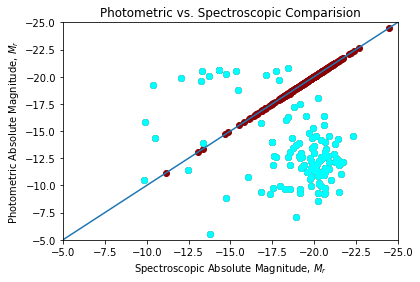

In [99]:
x = [-25, -5]
plt.scatter(scut_spec_table['abs_mag'], scut_spec_table['OLD_abs_mag'], color='darkred')
plt.plot(x, x) 
plt.scatter(scut_spec_table[diff_bool]['abs_mag'], scut_spec_table[diff_bool]['OLD_abs_mag'], color='cyan')
plt.title('Photometric vs. Spectroscopic Comparision')
plt.xlabel('Spectroscopic Absolute Magnitude, $M_r$')
plt.ylabel('Photometric Absolute Magnitude, $M_r$')
plt.xlim(-5,-25)
plt.ylim(-5,-25)

In [100]:
scut_spec_table[diff_bool].show_in_notebook()

idx,ID,SpecObjID,photoObjID,hostra,hostdec,SDSSra,SDSSdec,SDSSredshift,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,ra,dec,redshift,vflag,OLD_rmag,OLD_abs_mag,abs_mag
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,47914,1012215121411336192,1237657633260699874,138.7333,46.90333,138.73198,46.903084,0.01418223,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,138.7297916666666,46.900555555555556,0.014,1,20.84762,-12.267123693030832,-19.796023693030833
1,46384,1012215121411336192,1237657633260699874,138.7333,46.90333,138.73198,46.903084,0.01418223,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,138.73749999999995,46.906666666666666,0.014,1,20.84762,-12.267123693030832,-19.796023693030833
2,52852,960493540557744128,1237671991339516005,203.3631,5.482555,203.36689,5.4803297,0.02222189,16.79994,15.26885,14.77735,14.57,14.43348,0.04758821,0.008153033,0.006066226,0.006944962,0.02623263,0.1415546,0.1102984,0.0763039,0.05670198,0.04217585,203.36333333333332,5.482727777777778,0.022,0,22.33684,-11.759376918750672,-19.318866918750672
3,48463,928983734902876160,1237674365920739456,122.563,33.9566,122.56477,33.959741,0.0175046,21.00371,20.19089,19.25421,18.92378,18.63863,0.4095088,0.2513675,0.1820581,0.182665,0.1833335,0.2273574,0.1771553,0.1225552,0.09107167,0.06774059,122.56229166666664,33.95538888888889,0.01751,1,12.98961,-20.61092424505687,-14.34632424505687
4,47732,928983734902876160,1237674365920739456,122.563,33.9566,122.56477,33.959741,0.0175046,21.00371,20.19089,19.25421,18.92378,18.63863,0.4095088,0.2513675,0.1820581,0.182665,0.1833335,0.2273574,0.1771553,0.1225552,0.09107167,0.06774059,122.55708333333331,33.95827777777778,0.01751,1,12.98961,-20.61092424505687,-14.34632424505687
5,7549,862590549188700160,1237654652569845828,140.1435,50.69686,140.15505,50.700296,0.0776764,17.90118,16.9134,16.60552,16.35304,16.28379,0.02420026,0.00503104,0.005532302,0.006441854,0.02428737,0.06846204,0.05334516,0.03690393,0.02742358,0.0203981,140.14274999999998,50.696777777777775,0.0344,1,18.81042,-16.25647572749729,-18.46137572749729
6,51065,606951068215044096,1237655469670924584,224.5292,2.434167,224.52835,2.4384246,0.04373443,16.70506,15.53238,14.88652,14.53853,14.41896,0.03458157,0.006635923,0.005269607,0.005967412,0.01561306,0.2251217,0.1754133,0.1213501,0.09017615,0.06707449,224.53329166666663,2.43425,0.044,0,22.2352,-13.366166897070578,-20.714846897070576
7,48838,1051735418476718080,1237658205567909948,132.3458,36.71028,132.34402,36.710326,0.02506211,15.61743,14.21338,13.50321,13.17849,12.82506,0.02486414,0.01088594,0.01039128,0.01229386,0.009381895,0.1480886,0.1153896,0.079826,0.05931928,0.04412264,132.34266666666664,36.715722222222226,0.025114,0,22.91472,-11.468962964221152,-20.880472964221152
8,47073,1056204109213886464,1237657874865258512,138.521,40.1137,138.52591,40.120017,0.00858888,21.33617,20.41802,19.98046,19.86704,19.43862,0.3203627,0.1624087,0.1703273,0.1969186,0.2647915,0.06861603,0.05346514,0.03698694,0.02748526,0.02044398,138.50612499999997,40.10597222222222,0.00853,1,12.13367,-19.905178670477248,-12.05838867047725


In [101]:
# scut_spec_table[diff_bool].write('EDIT_diff_SpPh123.csv', format='ascii.csv')

### Re-Run

In [102]:
reRun_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/reRun_manualMags.csv', format='ascii.csv')

In [103]:
reRun_table['redshift'] = -999.

### Append redshift to reRun_table
for i in range(len(fcut_master_table)):
    SN_ID = fcut_master_table['ID'][i]
    idx_bool = reRun_table['ID'] == SN_ID
    reRun_table['redshift'][idx_bool] = fcut_master_table['redshift'][i]

In [104]:
### Absolute Magnitude calculation
reRun_table['abs_mag'] = abs_mag(reRun_table['petroMag_r'], reRun_table['redshift'])

In [105]:
reRun_table

ID,PhotoObjID,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,redshift,abs_mag
,,,,,,,,,,,,,,,,,,,,
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
426,1237651754021093484,204.62121731056,2.5282914990695,19.95297,19.06119,18.73739,18.5775,18.64286,0.08469753,0.04350778,0.05690788,0.06622602,0.1420933,0.09650095,0.07519288,0.05201809,0.03865502,0.02875223,0.017996,-14.922593437107285
52852,1237671991339516005,203.366858901976,5.48034871436981,16.79994,15.26885,14.77735,14.57,14.43348,0.04758821,0.008153033,0.006066226,0.006944962,0.02623263,0.1415546,0.1102984,0.0763039,0.05670198,0.04217585,0.022,-19.318866918750672
48838,1237658205567909948,132.343988919635,36.7103410956301,15.61743,14.21338,13.50321,13.17849,12.82506,0.02486414,0.01088594,0.01039128,0.01229386,0.009381895,0.1480886,0.1153896,0.079826,0.05931928,0.04412264,0.025114,-20.880472964221152
50661,1237658312939798567,179.042993620212,60.5225243221816,14.8936,13.3795,12.64625,12.27036,11.96952,0.01265024,0.002830642,0.003032876,0.002823786,0.005097464,0.0852119,0.06639653,0.04593281,0.034133,0.02538868,0.0333,-22.350074682171233
52256,1237657590321381529,177.008822259289,54.5774693526342,20.81696,19.94425,20.04376,19.70341,20.37756,0.1708238,0.0323895,0.05662484,0.06707428,0.5105635,0.05804048,0.04522475,0.03128627,0.02324905,0.01729302,0.0545,-16.022326026022853
46480,1237661358078427192,175.319281580172,47.6908105246674,14.97813,13.2727,12.48367,12.04816,11.94411,0.01692856,0.002897495,0.002609098,0.003379606,0.003050426,0.08051974,0.06274044,0.04340354,0.03225349,0.02399067,0.01057,-20.020808451176773
46355,1237665428645937516,241.530414701777,17.4608022280564,17.23248,15.47208,14.66014,14.23786,14.00452,0.03796724,0.01153848,0.01285654,0.01593017,0.01738479,0.1940697,0.1512178,0.1046118,0.07773775,0.0578226,0.0252,-19.730966218547366
47339,1237665102759329829,241.466634474356,21.48491456352,15.84085,13.45581,12.4595,11.93866,11.68042,0.05346148,0.006680416,0.006330609,0.005183657,0.004555421,0.3397938,0.264765,0.1831632,0.1361099,0.1012408,0.015,-20.805059809918042


(-5, -25)

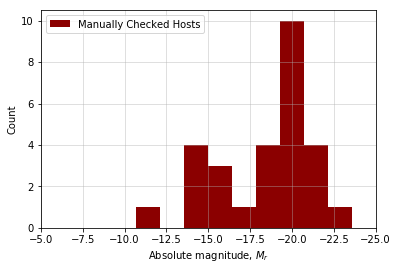

In [106]:
make_compHist(reRun_table['abs_mag'], np.linspace(-25, -5, 15), 'Manually Checked Hosts')
plt.xlim(-5,-25)

In [107]:
scut_spec_table['rerun_abs_mag'] = -999.
    
# ### Append correct abs_mag values to 'rerun' column
for i in range(len(scut_spec_table)):
    scut_spec_table['rerun_abs_mag'][i] = scut_spec_table['abs_mag'][i]
    
# ### Append rerun values to scut_spec_table
for i in range(len(reRun_table)):  
    SN_ID = reRun_table['ID'][i]
    idx_bool = scut_spec_table['ID'] == SN_ID
    scut_spec_table['rerun_abs_mag'][idx_bool] = reRun_table['abs_mag'][i]

In [108]:
scut_spec_table.show_in_notebook()

idx,ID,SpecObjID,photoObjID,hostra,hostdec,SDSSra,SDSSdec,SDSSredshift,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,ra,dec,redshift,vflag,OLD_rmag,OLD_abs_mag,abs_mag,rerun_abs_mag
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,47914,1012215121411336192,1237657633260699874,138.7333,46.90333,138.73198,46.903084,0.01418223,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,138.7297916666666,46.900555555555556,0.014,1,20.84762,-12.267123693030832,-19.796023693030833,-19.796023693030833
1,46384,1012215121411336192,1237657633260699874,138.7333,46.90333,138.73198,46.903084,0.01418223,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,138.73749999999995,46.906666666666666,0.014,1,20.84762,-12.267123693030832,-19.796023693030833,-19.796023693030833
2,53292,1009964695735527424,1237657770704437449,134.748,44.83058,134.74805,44.830595,0.04789706,18.53933,17.36878,17.02961,16.75984,16.67812,0.06435547,0.0104827,0.010886,0.01702177,0.05874692,0.08809423,0.06864243,0.04748652,0.03528757,0.02624747,134.74907499999998,44.83121666666667,0.0479,1,17.02961,-18.756171081712456,-18.756171081712456,-18.756171081712456
3,52674,1001027591320135680,1237657595683078624,116.4302,31.00856,116.43021,31.008608,0.06210726,18.90909,17.30345,16.38588,15.88615,15.56561,0.1297515,0.02598192,0.02386489,0.01760161,0.01793127,0.2383671,0.185734,0.1284899,0.09548178,0.0710209,116.43066666666665,31.007722222222224,0.062,0,16.38588,-19.96018196213091,-19.96018196213091,-19.96018196213091
4,52852,960493540557744128,1237671991339516005,203.3631,5.482555,203.36689,5.4803297,0.02222189,16.79994,15.26885,14.77735,14.57,14.43348,0.04758821,0.008153033,0.006066226,0.006944962,0.02623263,0.1415546,0.1102984,0.0763039,0.05670198,0.04217585,203.36333333333332,5.482727777777778,0.022,0,22.33684,-11.759376918750672,-19.318866918750672,-19.318866918750672
5,46778,951452806315796480,1237655123937001520,187.92,3.9263,187.92039,3.9263188,0.01510862,15.19202,13.76654,13.19738,12.94468,12.71065,0.05233434,0.09054002,0.09245452,0.09400122,0.08461305,0.1044479,0.08138506,0.05630181,0.04183828,0.03111999,187.92041666666665,3.9230555555555555,0.01511,1,13.19738,-20.08304583633476,-20.08304583633476,-20.08304583633476
6,54551,951435214129752064,1237668675623518317,188.1225,4.88875,188.12247,4.8887827,0.08277824,19.00992,17.83483,17.33247,17.01103,16.94851,0.09887942,0.01423734,0.009916445,0.01776873,0.07012024,0.08521064,0.06639556,0.04593214,0.0341325,0.02538831,188.1222833333333,4.888958333333333,0.082797,0,17.33247,-19.641706520602128,-19.641706520602128,-19.641706520602128
7,56169,946911823192418304,1237654604797837662,180.6513,4.549917,180.65136,4.5499441,0.0189063,19.34829,17.69456,17.28776,17.13502,17.50963,0.1859046,0.02162987,0.02153032,0.02644706,0.1317954,0.08013414,0.06243998,0.04319569,0.03209903,0.02387578,180.65099999999998,4.549888888888889,0.018848,1,17.28776,-16.472669880174678,-16.472669880174678,-16.472669880174678
8,46870,942510482625947648,1237655126078062738,173.168,5.3433,173.16781,5.3433006,0.02813233,18.07361,16.7111,16.26729,16.1715,16.11604,0.1167147,0.01917982,0.01323891,0.03031976,0.09804665,0.1129053,0.08797504,0.06086073,0.04522604,0.03363987,173.16899999999995,5.342099999999999,0.02814,1,16.26729,-18.36343398013327,-18.36343398013327,-18.36343398013327


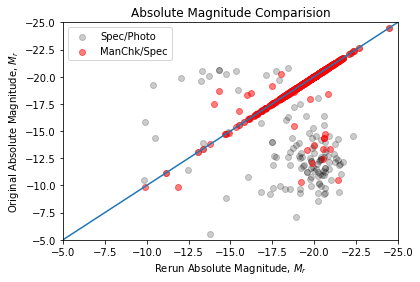

In [109]:
x = [-25, -5]
plt.scatter(scut_spec_table['abs_mag'], scut_spec_table['OLD_abs_mag'], color='black', alpha = 0.2, label='Spec/Photo')
plt.plot(x, x) 
plt.scatter(scut_spec_table['rerun_abs_mag'], scut_spec_table['abs_mag'], color='red', alpha=0.5, label='ManChk/Spec')
plt.title('Absolute Magnitude Comparision')
plt.xlabel('Rerun Absolute Magnitude, $M_r$')
plt.ylabel('Original Absolute Magnitude, $M_r$')
plt.xlim(-5,-25)
plt.ylim(-5,-25)
plt.legend()

### Nulls

In [110]:
null_sTable = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/SpecObj_petroMags_compare.csv', format='ascii.csv')

In [111]:
# null_sTable.remove_rows(nonNull_rows)

In [112]:
# null_sTable.write('null_manualCheck.csv', format='ascii.csv')

In [113]:
c_faint_bool    = scut_spec_table['abs_mag']>-15
spec_faint_table = scut_spec_table[c_faint_bool]

In [114]:
# spec_faint_table.write('spec_faint_manualCheck.csv', format='ascii.csv')

In [115]:
# spec_faint_table.show_in_notebook()

In [116]:
# null_sTable.show_in_notebook()
# null_sTable

In [117]:
null_SQL = null_sTable['ID','hostra','hostdec']

In [118]:
# null_SQL.write('null_SQL.csv', format='ascii.csv')

In [119]:
### Import rerun nulls (there are 99, not 145)
nonNull_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/photo_nonNull_mags.csv', format='ascii.csv')

In [120]:
nonNull_table

ID,PhotoObjID,hostra,hostdec,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
48889,1237653653447245873,3.963708,16.0898,3.96373118472638,16.0898219944754,14.86514,13.89323,13.34221,13.06441,12.77577,0.03079399,0.005972935,0.007576014,0.003576309,0.008845298,0.2649253,0.206428,0.1428059,0.1061201,0.07893386
46122,1237654605873479806,184.984,5.3433,184.983651668803,5.34332727066398,13.29192,12.20785,11.75713,11.50881,11.38914,0.005113323,0.002316741,0.001615942,0.001568626,0.00272199,0.07943714,0.06189688,0.04281997,0.03181983,0.02366811
50666,1237654605873479806,184.9833,5.343333,184.983651668803,5.34332727066398,13.29192,12.20785,11.75713,11.50881,11.38914,0.005113323,0.002316741,0.001615942,0.001568626,0.00272199,0.07943714,0.06189688,0.04281997,0.03181983,0.02366811
47099,1237657070091567119,41.6057,-0.4993,41.6048458267785,-0.498679226080309,12.22838,11.44188,11.1145,10.74985,10.67359,0.008877713,0.002910868,0.003391759,0.002908855,0.003250301,0.1464432,0.1141076,0.0789391,0.05866021,0.04363242
46721,1237658491745599505,187.169,9.2588,187.168831300928,9.25946246836735,14.39549,13.08391,12.49434,12.20575,12.0526,0.008647908,0.01255048,0.0115733,0.009163134,0.007595376,0.07993113,0.06228179,0.04308626,0.0320177,0.02381529
49476,1237663478726459897,343.707,-0.2526,343.707153728041,-0.252607336739087,19.32484,18.89359,18.5549,18.31492,18.26977,0.4183018,0.06179691,0.06655645,0.083184,0.2826411,0.3540351,0.2758618,0.1908399,0.1418145,0.1054839
50361,1237663783662257166,3.905083,-0.38847,3.90505804583059,-0.388444531347675,25.2506,26.6377,22.89009,21.88515,22.56898,1.030597,0.4576813,0.4254987,0.3012033,1.687514,0.1567745,0.1221577,0.08450811,0.06279857,0.0467106
49528,1237664292075274273,183.4083,16.11944,183.409345859137,16.1196173541526,21.22303,20.75667,20.72673,20.73082,21.32095,0.2670335,0.223758,0.216676,0.2622291,0.8473089,0.1579754,0.1230933,0.0851554,0.06327958,0.04706839
52300,1237665328779231263,186.6125,31.22333,186.612681074018,31.2311988688613,24.63482,22.66184,20.33192,19.47016,19.07873,3.819757,1.118204,0.2059897,0.1740363,0.2545422,0.08232474,0.06414688,0.04437651,0.0329765,0.02452846


In [121]:
### Append redshift
nonNull_table['redshift'] = -999.

for i in range(len(master_table_cut)):
    SN_ID = master_table_cut['ID'][i]
    idx_bool = nonNull_table['ID'] == SN_ID
    nonNull_table['redshift'][idx_bool] = master_table_cut['redshift'][i]

In [122]:
nonNull_table['abs_mag'] = abs_mag(nonNull_table['petroMag_r'], nonNull_table['redshift'])

In [123]:
### Append vflag
nonNull_table['vflag'] = -9

for i in range(len(master_table_cut)):
    SN_ID = master_table_cut['ID'][i]
    idx_bool = nonNull_table['ID'] == SN_ID
    nonNull_table['vflag'][idx_bool] = master_table_cut['vflag'][i]

In [124]:
### Cut vflag == 2 OR 9
nNull_cut1 = nonNull_table['vflag'] != 9
vflag_nonNull_table = nonNull_table[nNull_cut1]

nNull_cut2 = vflag_nonNull_table['vflag'] != 2
vflag_nonNull_table = vflag_nonNull_table[nNull_cut2]

In [125]:
vflag_nonNull_table.show_in_notebook()

idx,ID,PhotoObjID,hostra,hostdec,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,redshift,abs_mag,vflag
,,,,,,,,,,,,,,,,,,,,,,,,
0,49528,1237664292075274273,183.4083,16.11944,183.409345859137,16.1196173541526,21.22303,20.75667,20.72673,20.73082,21.32095,0.2670335,0.223758,0.216676,0.2622291,0.8473089,0.1579754,0.1230933,0.0851554,0.06327958,0.04706839,0.024,-13.558429723197666,0
1,48960,1237667447801381057,179.4458,25.27167,179.446364297681,25.2742379484833,23.06273,22.36711,21.9725,21.6986,20.57262,108.4332,51.25901,94.12054,121.7059,2.840202,0.08819058,0.0687175,0.04753845,0.03532616,0.02627617,0.016,-11.432203427919259,1
2,52007,1237668367459418482,235.3,15.57306,235.300476646709,15.5729960168153,15.70026,14.68141,14.23047,14.04741,13.86413,0.02967228,0.01714174,0.007682539,0.008002983,0.01369493,0.1624518,0.1265814,0.08756841,0.06507272,0.04840214,0.013513,-18.80739239846535,0
3,46753,1237667448879448236,190.4083,26.07472,190.406990252723,26.0747145181423,23.05175,21.37611,21.179,21.12064,21.56425,1.295358,0.2392272,0.2414106,0.3497292,1.097046,0.06452215,0.05027523,0.03478017,0.02584539,0.01922422,0.016,-12.22570342791926,1
4,47349,1237667252933754939,163.5875,27.24,163.589785419275,27.2417597591235,23.44122,23.82857,22.55662,24.36186,22.54418,1.377313,1.550651,0.6684244,2.792458,1.736261,0.09226637,0.07189333,0.04973548,0.03695879,0.02749055,0.0044,-8.044746897070578,1
5,47972,1237661387065786478,205.415,55.6707,205.415085612997,55.6706520974752,15.73674,14.04154,13.25705,12.83987,12.53244,0.02850289,0.009661102,0.007644725,0.007225192,0.005690246,0.03992765,0.03111136,0.02152269,0.01599367,0.01189635,0.02597,-21.199413262786152,1
6,47475,1237668624630284403,202.3292,17.05167,202.329848435474,17.0517482013978,15.46382,13.20131,12.33001,12.17376,12.01951,0.03541839,0.06583235,0.02499644,0.009265607,0.06025628,0.08277892,0.06450077,0.04462134,0.03315844,0.02466378,0.0136,-20.721788056490723,1
7,47955,1237668624630284403,202.3292,17.05167,202.329848435474,17.0517482013978,15.46382,13.20131,12.33001,12.17376,12.01951,0.03541839,0.06583235,0.02499644,0.009265607,0.06025628,0.08277892,0.06450077,0.04462134,0.03315844,0.02466378,0.013,-20.62381027617382,1
8,50959,1237668289617985540,149.0833,16.83167,149.083248500487,16.8313568233481,21.36198,19.68341,18.82029,18.35022,17.96301,0.3608053,0.1734468,0.173859,0.1774511,0.1846134,0.1238393,0.09649477,0.06675464,0.04960585,0.03689764,0.0123,-14.013339071836626,1


(-5, -25)

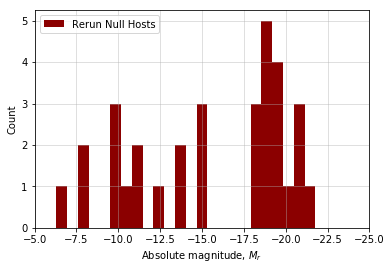

In [126]:
make_compHist(vflag_nonNull_table['abs_mag'], np.linspace(-25, -5, 32), 'Rerun Null Hosts')
plt.xlim(-5,-25)

In [127]:
nN_bool = vflag_nonNull_table['abs_mag'] > -15.

In [128]:
vflag_nonNull_table[nN_bool].show_in_notebook()

idx,ID,PhotoObjID,hostra,hostdec,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,redshift,abs_mag,vflag
,,,,,,,,,,,,,,,,,,,,,,,,
0,49528,1237664292075274273,183.4083,16.11944,183.409345859137,16.1196173541526,21.22303,20.75667,20.72673,20.73082,21.32095,0.2670335,0.223758,0.216676,0.2622291,0.8473089,0.1579754,0.1230933,0.0851554,0.06327958,0.04706839,0.024,-13.558429723197666,0
1,48960,1237667447801381057,179.4458,25.27167,179.446364297681,25.2742379484833,23.06273,22.36711,21.9725,21.6986,20.57262,108.4332,51.25901,94.12054,121.7059,2.840202,0.08819058,0.0687175,0.04753845,0.03532616,0.02627617,0.016,-11.432203427919259,1
2,46753,1237667448879448236,190.4083,26.07472,190.406990252723,26.0747145181423,23.05175,21.37611,21.179,21.12064,21.56425,1.295358,0.2392272,0.2414106,0.3497292,1.097046,0.06452215,0.05027523,0.03478017,0.02584539,0.01922422,0.016,-12.22570342791926,1
3,47349,1237667252933754939,163.5875,27.24,163.589785419275,27.2417597591235,23.44122,23.82857,22.55662,24.36186,22.54418,1.377313,1.550651,0.6684244,2.792458,1.736261,0.09226637,0.07189333,0.04973548,0.03695879,0.02749055,0.0044,-8.044746897070578,1
4,50959,1237668289617985540,149.0833,16.83167,149.083248500487,16.8313568233481,21.36198,19.68341,18.82029,18.35022,17.96301,0.3608053,0.1734468,0.173859,0.1774511,0.1846134,0.1238393,0.09649477,0.06675464,0.04960585,0.03689764,0.0123,-14.013339071836626,1
5,48149,1237667446192209932,182.9667,24.12333,182.966549033652,24.1231469021648,21.69596,21.25939,21.88194,24.36193,22.82705,28.32433,31.71331,105.3811,836.3145,374.3064,0.1511993,0.1178135,0.08150282,0.06056533,0.04504948,0.0086,-10.174655770857477,1
6,47627,1237665368509710426,174.925,31.90972,174.925682229559,31.9085792912916,21.01456,18.49213,17.3052,17.21962,17.36141,0.2647816,0.08624131,0.06964637,0.09665567,0.1399957,0.1011695,0.07883057,0.05453463,0.04052507,0.03014321,0.008933,-14.833890184583659,1
7,52629,1237664869211504804,137.3875,33.12361,137.386967921473,33.1243052414836,23.35211,21.98606,21.75722,21.196,21.60824,1.51049,0.3402593,0.4329466,0.3354703,1.059037,0.09563673,0.07451949,0.05155224,0.03830884,0.02849474,0.0064,-9.657783384559075,1
8,50650,1237664869211504804,137.3875,33.12361,137.386967921473,33.1243052414836,23.35211,21.98606,21.75722,21.196,21.60824,1.51049,0.3402593,0.4329466,0.3354703,1.059037,0.09563673,0.07451949,0.05155224,0.03830884,0.02849474,0.0065,-9.691450297853915,1


In [129]:
nNmC_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/nonNull_manChkMags.csv', format='ascii.csv')

In [130]:
nNmC_table

ID,PhotoObjID,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
49528,1237664292075274266,183.406875537258,16.1195252408702,15.67253,14.86902,14.58281,14.4117,14.62163,0.05978688,0.07494988,0.123394,0.1328388,0.1518892,0.1579119,0.1230439,0.08512118,0.06325416,0.04704947
48960,1237667447801381023,179.450994655177,25.2706366418139,15.61165,14.82668,14.39681,14.23073,14.0611,0.01991757,0.02630819,0.02465588,0.02507077,0.02657628,0.08840896,0.06888767,0.04765617,0.03541364,0.02634124
46753,1237667448879448226,190.405489568001,26.0728230034413,14.63362,13.86213,13.40313,13.16939,13.02904,0.05667016,0.02079704,0.01947062,0.01709439,0.02248981,0.06440841,0.0501866,0.03471886,0.02579983,0.01919034
47349,1237667252933754936,163.584190209766,27.2380642090559,14.66343,13.45146,12.97293,12.54263,12.46043,0.02308596,0.009304798,0.004615505,0.01035257,0.00869509,0.09225658,0.0718857,0.0497302,0.03695486,0.02748763
50959,1237668289617920079,149.079877427885,16.8311896054506,15.13279,13.59254,12.78591,12.3756,11.9581,0.02174942,0.01546794,0.009811084,0.008836952,0.01113359,0.123754,0.09642828,0.06670864,0.04957167,0.03687222
48149,1237667446192209928,182.968726319888,24.1236184140119,14.95686,13.20823,12.53922,12.11757,11.8393,0.03972081,0.03127906,0.03427567,0.02589173,0.01943615,0.1512608,0.1178614,0.08153598,0.06058997,0.04506781
47627,1237665368509710424,174.927178054097,31.9093838664679,15.13787,13.1887,12.35164,12.04935,11.8005,0.02871194,0.009737024,0.01094898,0.01010885,0.005393571,0.1011586,0.07882206,0.05452874,0.0405207,0.03013995
52629,1237664869211504785,137.391036955751,33.1228776960457,24.63452,25.11429,24.80193,21.21605,20.5375,7.138099,21.55821,28.52634,2.683122,1.981668,0.09561202,0.07450024,0.05153892,0.03829894,0.02848738
50650,1237664869211504785,137.391036955751,33.1228776960457,24.63452,25.11429,24.80193,21.21605,20.5375,7.138099,21.55821,28.52634,2.683122,1.981668,0.09561202,0.07450024,0.05153892,0.03829894,0.02848738


In [131]:
nNmC_table['redshift'] = -999.

### Append redshift to reRun_table
for i in range(len(fcut_master_table)):
    SN_ID = fcut_master_table['ID'][i]
    idx_bool = nNmC_table['ID'] == SN_ID
    nNmC_table['redshift'][idx_bool] = fcut_master_table['redshift'][i]

In [132]:
### Absolute Magnitude calculation
nNmC_table['abs_mag'] = abs_mag(nNmC_table['petroMag_r'], nNmC_table['redshift'])

In [133]:
vflag_nonNull_table['rerun_abs_mag'] = -999.
    
# ### Append correct abs_mag values to 'rerun' column
for i in range(len(vflag_nonNull_table)):
    vflag_nonNull_table['rerun_abs_mag'][i] = vflag_nonNull_table['abs_mag'][i]
    
# ### Append rerun values to scut_spec_table
for i in range(len(nNmC_table)):  
    SN_ID = nNmC_table['ID'][i]
    idx_bool = vflag_nonNull_table['ID'] == SN_ID
    vflag_nonNull_table['rerun_abs_mag'][idx_bool] = vflag_nonNull_table['abs_mag'][i]

In [134]:
vflag_nonNull_table.show_in_notebook()

idx,ID,PhotoObjID,hostra,hostdec,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,redshift,abs_mag,vflag,rerun_abs_mag
,,,,,,,,,,,,,,,,,,,,,,,,,
0,49528,1237664292075274273,183.4083,16.11944,183.409345859137,16.1196173541526,21.22303,20.75667,20.72673,20.73082,21.32095,0.2670335,0.223758,0.216676,0.2622291,0.8473089,0.1579754,0.1230933,0.0851554,0.06327958,0.04706839,0.024,-13.558429723197666,0,-13.558429723197666
1,48960,1237667447801381057,179.4458,25.27167,179.446364297681,25.2742379484833,23.06273,22.36711,21.9725,21.6986,20.57262,108.4332,51.25901,94.12054,121.7059,2.840202,0.08819058,0.0687175,0.04753845,0.03532616,0.02627617,0.016,-11.432203427919259,1,-11.432203427919259
2,52007,1237668367459418482,235.3,15.57306,235.300476646709,15.5729960168153,15.70026,14.68141,14.23047,14.04741,13.86413,0.02967228,0.01714174,0.007682539,0.008002983,0.01369493,0.1624518,0.1265814,0.08756841,0.06507272,0.04840214,0.013513,-18.80739239846535,0,-18.80739239846535
3,46753,1237667448879448236,190.4083,26.07472,190.406990252723,26.0747145181423,23.05175,21.37611,21.179,21.12064,21.56425,1.295358,0.2392272,0.2414106,0.3497292,1.097046,0.06452215,0.05027523,0.03478017,0.02584539,0.01922422,0.016,-12.22570342791926,1,-18.80739239846535
4,47349,1237667252933754939,163.5875,27.24,163.589785419275,27.2417597591235,23.44122,23.82857,22.55662,24.36186,22.54418,1.377313,1.550651,0.6684244,2.792458,1.736261,0.09226637,0.07189333,0.04973548,0.03695879,0.02749055,0.0044,-8.044746897070578,1,-12.22570342791926
5,47972,1237661387065786478,205.415,55.6707,205.415085612997,55.6706520974752,15.73674,14.04154,13.25705,12.83987,12.53244,0.02850289,0.009661102,0.007644725,0.007225192,0.005690246,0.03992765,0.03111136,0.02152269,0.01599367,0.01189635,0.02597,-21.199413262786152,1,-21.199413262786152
6,47475,1237668624630284403,202.3292,17.05167,202.329848435474,17.0517482013978,15.46382,13.20131,12.33001,12.17376,12.01951,0.03541839,0.06583235,0.02499644,0.009265607,0.06025628,0.08277892,0.06450077,0.04462134,0.03315844,0.02466378,0.0136,-20.721788056490723,1,-20.721788056490723
7,47955,1237668624630284403,202.3292,17.05167,202.329848435474,17.0517482013978,15.46382,13.20131,12.33001,12.17376,12.01951,0.03541839,0.06583235,0.02499644,0.009265607,0.06025628,0.08277892,0.06450077,0.04462134,0.03315844,0.02466378,0.013,-20.62381027617382,1,-20.62381027617382
8,50959,1237668289617985540,149.0833,16.83167,149.083248500487,16.8313568233481,21.36198,19.68341,18.82029,18.35022,17.96301,0.3608053,0.1734468,0.173859,0.1774511,0.1846134,0.1238393,0.09649477,0.06675464,0.04960585,0.03689764,0.0123,-14.013339071836626,1,-8.044746897070578


In [135]:
vflag_nonNull_table = vflag_nonNull_table['ID','PhotoObjID','hostra','hostdec','SDSSra','SDSSdec','petroMag_u','petroMag_g','petroMag_r','petroMag_i','petroMag_z','petroMagErr_u','petroMagErr_g','petroMagErr_r','petroMagErr_i','petroMagErr_z','extinction_u','extinction_g','extinction_r','extinction_i','extinction_z','redshift','vflag','abs_mag','rerun_abs_mag']
del scut_spec_table['SpecObjID','SDSSredshift','ra','dec','OLD_rmag','OLD_abs_mag']

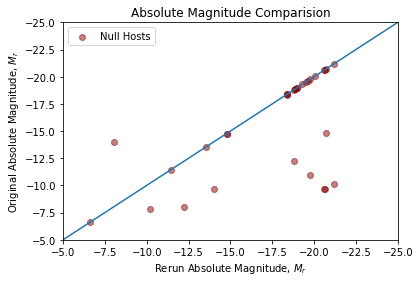

In [136]:
plt.scatter(vflag_nonNull_table['rerun_abs_mag'], vflag_nonNull_table['abs_mag'], color='darkred', alpha = 0.5, label='Null Hosts')
x = [-25, -5]
plt.plot(x, x) 
plt.title('Absolute Magnitude Comparision')
plt.xlabel('Rerun Absolute Magnitude, $M_r$')
plt.ylabel('Original Absolute Magnitude, $M_r$')
plt.xlim(-5,-25)
plt.ylim(-5,-25)
plt.legend()

# K-Correction

In [137]:
scut_spec_table['petroMag_u'] = scut_spec_table['petroMag_u'].astype(float)
scut_spec_table['petroMag_g'] = scut_spec_table['petroMag_g'].astype(float)
scut_spec_table['petroMag_i'] = scut_spec_table['petroMag_i'].astype(float)
scut_spec_table['petroMag_z'] = scut_spec_table['petroMag_z'].astype(float)
scut_spec_table['petroMagErr_u'] = scut_spec_table['petroMagErr_u'].astype(float)
scut_spec_table['petroMagErr_g'] = scut_spec_table['petroMagErr_g'].astype(float)
scut_spec_table['petroMagErr_r'] = scut_spec_table['petroMagErr_r'].astype(float)
scut_spec_table['petroMagErr_i'] = scut_spec_table['petroMagErr_i'].astype(float)
scut_spec_table['petroMagErr_z'] = scut_spec_table['petroMagErr_z'].astype(float)
scut_spec_table['extinction_u'] = scut_spec_table['extinction_u'].astype(float)
scut_spec_table['extinction_g'] = scut_spec_table['extinction_g'].astype(float)
scut_spec_table['extinction_r'] = scut_spec_table['extinction_r'].astype(float)
scut_spec_table['extinction_i'] = scut_spec_table['extinction_i'].astype(float)
scut_spec_table['extinction_z'] = scut_spec_table['extinction_z'].astype(float)

In [138]:
### Append 'vflag_nonNull_table' and 'scut_spec_table' to one table.

for i in range(len(vflag_nonNull_table)):
    scut_spec_table.add_row(vflag_nonNull_table[i])

In [139]:
scut_spec_table

ID,photoObjID,hostra,hostdec,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,redshift,vflag,abs_mag,rerun_abs_mag
,,,,,,,,,,,,,,,,,,,,,,,,
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64
47914,1237657633260699874,138.7333,46.90333,138.73198,46.903084,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,0.014,1,-19.796023693030833,-19.796023693030833
46384,1237657633260699874,138.7333,46.90333,138.73198,46.903084,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,0.014,1,-19.796023693030833,-19.796023693030833
53292,1237657770704437449,134.748,44.83058,134.74805,44.830595,18.53933,17.36878,17.02961,16.75984,16.67812,0.06435547,0.0104827,0.010886,0.01702177,0.05874692,0.08809423,0.06864243,0.04748652,0.03528757,0.02624747,0.0479,1,-18.756171081712456,-18.756171081712456
52674,1237657595683078624,116.4302,31.00856,116.43021,31.008608,18.90909,17.30345,16.38588,15.88615,15.56561,0.1297515,0.02598192,0.02386489,0.01760161,0.01793127,0.2383671,0.185734,0.1284899,0.09548178,0.0710209,0.062,0,-19.96018196213091,-19.96018196213091
52852,1237671991339516005,203.3631,5.482555,203.36689,5.4803297,16.79994,15.26885,14.77735,14.57,14.43348,0.04758821,0.008153033,0.006066226,0.006944962,0.02623263,0.1415546,0.1102984,0.0763039,0.05670198,0.04217585,0.022,0,-19.318866918750672,-19.318866918750672
46778,1237655123937001520,187.92,3.9263,187.92039,3.9263188,15.19202,13.76654,13.19738,12.94468,12.71065,0.05233434,0.09054002,0.09245452,0.09400122,0.08461305,0.1044479,0.08138506,0.05630181,0.04183828,0.03111999,0.01511,1,-20.08304583633476,-20.08304583633476
54551,1237668675623518317,188.1225,4.88875,188.12247,4.8887827,19.00992,17.83483,17.33247,17.01103,16.94851,0.09887942,0.01423734,0.009916445,0.01776873,0.07012024,0.08521064,0.06639556,0.04593214,0.0341325,0.02538831,0.082797,0,-19.641706520602128,-19.641706520602128
56169,1237654604797837662,180.6513,4.549917,180.65136,4.5499441,19.34829,17.69456,17.28776,17.13502,17.50963,0.1859046,0.02162987,0.02153032,0.02644706,0.1317954,0.08013414,0.06243998,0.04319569,0.03209903,0.02387578,0.018848,1,-16.472669880174678,-16.472669880174678


In [140]:
# scut_spec_table.write('kCorr_SQL.txt', format='ascii.commented_header')

In [141]:
scut_spec_table.remove_columns(['ID','hostra','hostdec','SDSSra','SDSSdec','petroMag_u','petroMag_g','petroMag_r','petroMag_i','petroMag_z','petroMagErr_u','petroMagErr_g','petroMagErr_r','petroMagErr_i','petroMagErr_z','extinction_u','extinction_g','extinction_r','extinction_i','extinction_z','redshift','vflag','abs_mag','rerun_abs_mag'])

In [142]:
scut_spec_table

photoObjID
str19
1237657633260699874
1237657633260699874
1237657770704437449
1237657595683078624
1237671991339516005
1237655123937001520
1237668675623518317
1237654604797837662
1237655126078062738


In [144]:
# scut_spec_table.write('poID.txt', format='ascii.commented_header')

In [145]:
kcorr_fields_1 = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/kcorr_fields.csv', format='ascii.csv')

In [146]:
### Append redshift
kcorr_fields_1['redshift'] = -999.
kcorr_fields_1['vflag'] = -9

### Append redshift to reRun_table
for i in range(len(master_table_cut)):
    SN_ID = master_table_cut['ID'][i]
    idx_bool = kcorr_fields_1['ID'] == SN_ID
    kcorr_fields_1['redshift'][idx_bool] = master_table_cut['redshift'][i]
    kcorr_fields_1['vflag'][idx_bool] = master_table_cut['vflag'][i]

In [147]:
kcorr_fields_1

ID,PhotoObjID,petroMag_r,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroFluxIvar_u,petroFluxIvar_g,petroFluxIvar_r,petroFluxIvar_i,petroFluxIvar_z,redshift,vflag
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
1584,1237648702975639736,17.40083,13.55162,51.79935,109.5642,174.5976,209.9846,0.2525832,0.9364166,0.2138519,0.04560144,0.007166579,0.08,0
465,1237648721246290147,16.76493,35.88984,114.7558,196.8004,271.1425,336.078,0.5335513,1.17267,0.3286604,0.2148645,0.01928493,0.054,0
419,1237648722304172344,16.42431,50.16409,166.9515,269.3255,357.5386,410.3102,0.1299727,0.4016777,0.1511707,0.05949091,0.006975508,0.06227,1
48713,1237648722308759778,13.93589,599.8012,1958.822,2664.681,3273.064,3576.054,0.006700986,0.008123346,0.002684339,0.003650065,0.0003493085,0.01697,1
736,1237648722312495178,17.55096,16.30651,63.78194,95.41478,125.7909,111.5575,0.1726735,0.7757944,0.2362777,0.07570177,0.004488167,0.073,0
1456,1237648722829639753,15.97771,46.22793,184.255,406.3665,615.2534,806.7346,0.09679973,0.2724952,0.1181645,0.05304561,0.004517071,0.094,0
55449,1237651066813087901,16.50294,65.58957,181.5529,250.5088,299.1606,242.7571,0.0406139,0.1270622,0.07902859,0.01937909,0.00136242,0.035322,1
4568,1237651190282911866,16.91579,46.75436,127.0827,171.2707,215.9147,247.0162,0.1618335,0.6721759,0.3355136,0.1451811,0.01066191,0.05,1
52219,1237651190825877669,16.05543,106.6762,266.839,378.2942,471.722,534.0398,0.1153201,0.3467748,0.1457141,0.06575497,0.005894946,0.03013,0


In [148]:
kC_cut1 = kcorr_fields_1['vflag'] != -9
kcorr_fields_1 = kcorr_fields_1[kC_cut1]

kC_cut2 = kcorr_fields_1['vflag'] != 9
kcorr_fields_1 = kcorr_fields_1[kC_cut2]

kC_cut3 = kcorr_fields_1['vflag'] != 2
kcorr_fields_1 = kcorr_fields_1[kC_cut3]

In [149]:
kcorr_fields_1

ID,PhotoObjID,petroMag_r,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroFluxIvar_u,petroFluxIvar_g,petroFluxIvar_r,petroFluxIvar_i,petroFluxIvar_z,redshift,vflag
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
1584,1237648702975639736,17.40083,13.55162,51.79935,109.5642,174.5976,209.9846,0.2525832,0.9364166,0.2138519,0.04560144,0.007166579,0.08,0
465,1237648721246290147,16.76493,35.88984,114.7558,196.8004,271.1425,336.078,0.5335513,1.17267,0.3286604,0.2148645,0.01928493,0.054,0
419,1237648722304172344,16.42431,50.16409,166.9515,269.3255,357.5386,410.3102,0.1299727,0.4016777,0.1511707,0.05949091,0.006975508,0.06227,1
48713,1237648722308759778,13.93589,599.8012,1958.822,2664.681,3273.064,3576.054,0.006700986,0.008123346,0.002684339,0.003650065,0.0003493085,0.01697,1
736,1237648722312495178,17.55096,16.30651,63.78194,95.41478,125.7909,111.5575,0.1726735,0.7757944,0.2362777,0.07570177,0.004488167,0.073,0
1456,1237648722829639753,15.97771,46.22793,184.255,406.3665,615.2534,806.7346,0.09679973,0.2724952,0.1181645,0.05304561,0.004517071,0.094,0
55449,1237651066813087901,16.50294,65.58957,181.5529,250.5088,299.1606,242.7571,0.0406139,0.1270622,0.07902859,0.01937909,0.00136242,0.035322,1
4568,1237651190282911866,16.91579,46.75436,127.0827,171.2707,215.9147,247.0162,0.1618335,0.6721759,0.3355136,0.1451811,0.01066191,0.05,1
52219,1237651190825877669,16.05543,106.6762,266.839,378.2942,471.722,534.0398,0.1153201,0.3467748,0.1457141,0.06575497,0.005894946,0.03013,0


In [150]:
kcorr_fields_1.remove_columns(['PhotoObjID', 'petroMag_r', 'vflag'])

In [151]:
kcorr_fields_1['petroFlux_u'] = kcorr_fields_1['petroFlux_u']*(1E-9)
kcorr_fields_1['petroFlux_g'] = kcorr_fields_1['petroFlux_g']*(1E-9)
kcorr_fields_1['petroFlux_r'] = kcorr_fields_1['petroFlux_r']*(1E-9)
kcorr_fields_1['petroFlux_i'] = kcorr_fields_1['petroFlux_i']*(1E-9)
kcorr_fields_1['petroFlux_z'] = kcorr_fields_1['petroFlux_z']*(1E-9)
kcorr_fields_1['petroFluxIvar_u'] = kcorr_fields_1['petroFluxIvar_u']*(1E-18)
kcorr_fields_1['petroFluxIvar_g'] = kcorr_fields_1['petroFluxIvar_g']*(1E-18)
kcorr_fields_1['petroFluxIvar_r'] = kcorr_fields_1['petroFluxIvar_r']*(1E-18)
kcorr_fields_1['petroFluxIvar_i'] = kcorr_fields_1['petroFluxIvar_i']*(1E-18)
kcorr_fields_1['petroFluxIvar_z'] = kcorr_fields_1['petroFluxIvar_z']*(1E-18)

In [152]:
kcorr_fields_1.remove_column('ID')

In [153]:
kcorr_fields_1 = kcorr_fields_1['redshift','petroFlux_u','petroFlux_g','petroFlux_r','petroFlux_i','petroFlux_z','petroFluxIvar_u','petroFluxIvar_g','petroFluxIvar_r','petroFluxIvar_i','petroFluxIvar_z']

In [154]:
kcorr_fields_1

redshift,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroFluxIvar_u,petroFluxIvar_g,petroFluxIvar_r,petroFluxIvar_i,petroFluxIvar_z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.08,1.355162e-08,5.179935e-08,1.0956420000000001e-07,1.7459760000000002e-07,2.0998460000000002e-07,2.5258320000000003e-19,9.364166000000001e-19,2.1385190000000003e-19,4.560144e-20,7.166579000000001e-21
0.054,3.588984e-08,1.147558e-07,1.968004e-07,2.711425e-07,3.36078e-07,5.335513e-19,1.1726700000000001e-18,3.2866040000000003e-19,2.1486450000000003e-19,1.928493e-20
0.06227,5.016409000000001e-08,1.669515e-07,2.6932549999999997e-07,3.575386e-07,4.103102e-07,1.299727e-19,4.0167770000000006e-19,1.511707e-19,5.949091e-20,6.975508000000001e-21
0.01697,5.998012000000001e-07,1.958822e-06,2.664681e-06,3.273064e-06,3.5760540000000004e-06,6.7009860000000005e-21,8.123346e-21,2.684339e-21,3.650065e-21,3.493085e-22
0.073,1.630651e-08,6.378194e-08,9.541478e-08,1.257909e-07,1.1155750000000001e-07,1.7267350000000001e-19,7.757944e-19,2.362777e-19,7.570177000000001e-20,4.488167e-21
0.094,4.6227930000000006e-08,1.84255e-07,4.063665e-07,6.152534000000001e-07,8.067346000000001e-07,9.679973000000001e-20,2.7249520000000004e-19,1.1816450000000002e-19,5.3045610000000004e-20,4.517071e-21
0.035322,6.558957e-08,1.815529e-07,2.505088e-07,2.991606e-07,2.427571e-07,4.0613900000000004e-20,1.270622e-19,7.902859e-20,1.9379090000000002e-20,1.3624200000000001e-21
0.05,4.675436e-08,1.270827e-07,1.7127070000000002e-07,2.1591470000000003e-07,2.4701620000000003e-07,1.618335e-19,6.721759000000001e-19,3.3551360000000005e-19,1.4518110000000002e-19,1.0661910000000001e-20
0.03013,1.066762e-07,2.66839e-07,3.782942e-07,4.71722e-07,5.340398e-07,1.1532010000000001e-19,3.467748e-19,1.4571410000000003e-19,6.575497e-20,5.894946e-21


In [155]:
# kcorr_fields_1.write('petroFlux_allBands.txt', format='ascii.no_header', overwrite=True)

In [156]:
kcorr_fields_2 = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/kcorr_fields.csv', format='ascii.csv')

In [160]:
### Append redshift and vflag
kcorr_fields_2['redshift'] = -999.
kcorr_fields_2['vflag'] = -9

for i in range(len(master_table_cut)):
    SN_ID = master_table_cut['ID'][i]
    idx_bool = kcorr_fields_2['ID'] == SN_ID
    kcorr_fields_2['redshift'][idx_bool] = master_table_cut['redshift'][i]
    kcorr_fields_2['vflag'][idx_bool] = master_table_cut['vflag'][i]

In [161]:
kcorr_fields_2

ID,PhotoObjID,petroMag_r,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroFluxIvar_u,petroFluxIvar_g,petroFluxIvar_r,petroFluxIvar_i,petroFluxIvar_z,redshift,vflag
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
1584,1237648702975639736,17.40083,13.55162,51.79935,109.5642,174.5976,209.9846,0.2525832,0.9364166,0.2138519,0.04560144,0.007166579,0.08,0
465,1237648721246290147,16.76493,35.88984,114.7558,196.8004,271.1425,336.078,0.5335513,1.17267,0.3286604,0.2148645,0.01928493,0.054,0
419,1237648722304172344,16.42431,50.16409,166.9515,269.3255,357.5386,410.3102,0.1299727,0.4016777,0.1511707,0.05949091,0.006975508,0.06227,1
48713,1237648722308759778,13.93589,599.8012,1958.822,2664.681,3273.064,3576.054,0.006700986,0.008123346,0.002684339,0.003650065,0.0003493085,0.01697,1
736,1237648722312495178,17.55096,16.30651,63.78194,95.41478,125.7909,111.5575,0.1726735,0.7757944,0.2362777,0.07570177,0.004488167,0.073,0
1456,1237648722829639753,15.97771,46.22793,184.255,406.3665,615.2534,806.7346,0.09679973,0.2724952,0.1181645,0.05304561,0.004517071,0.094,0
55449,1237651066813087901,16.50294,65.58957,181.5529,250.5088,299.1606,242.7571,0.0406139,0.1270622,0.07902859,0.01937909,0.00136242,0.035322,1
4568,1237651190282911866,16.91579,46.75436,127.0827,171.2707,215.9147,247.0162,0.1618335,0.6721759,0.3355136,0.1451811,0.01066191,0.05,1
52219,1237651190825877669,16.05543,106.6762,266.839,378.2942,471.722,534.0398,0.1153201,0.3467748,0.1457141,0.06575497,0.005894946,0.03013,0


In [162]:
kC_cut1_2 = kcorr_fields_2['vflag'] != -9
kcorr_fields_2 = kcorr_fields_2[kC_cut1_2]

kC_cut2_2 = kcorr_fields_2['vflag'] != 9
kcorr_fields_2 = kcorr_fields_2[kC_cut2_2]

kC_cut3_2 = kcorr_fields_2['vflag'] != 2
kcorr_fields_2 = kcorr_fields_2[kC_cut3_2]

In [163]:
kcorr_fields_2.remove_columns(['petroFlux_u','petroFlux_g','petroFlux_r','petroFlux_i','petroFlux_z','petroFluxIvar_u','petroFluxIvar_g','petroFluxIvar_r','petroFluxIvar_i','petroFluxIvar_z','vflag'])

In [164]:
kcorr_fields_2.remove_column('PhotoObjID')

In [165]:
kcorr_fields_2 = kcorr_fields_2['ID','redshift','petroMag_r']

In [166]:
kcorr_fields_2

ID,redshift,petroMag_r
int32,float64,float64
1584,0.08,17.40083
465,0.054,16.76493
419,0.06227,16.42431
48713,0.01697,13.93589
736,0.073,17.55096
1456,0.094,15.97771
55449,0.035322,16.50294
4568,0.05,16.91579
52219,0.03013,16.05543


In [167]:
# kcorr_fields_2.write('petroMag_rBand.txt', format='ascii.commented_header', overwrite=True)

# AFTER K-CORRECTION, FINDING RATES

In [168]:
kcorr_absmag = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/petroMag_rBand_rabsmag.txt', format='ascii.commented_header')

In [169]:
kcorr_absmag

ID,redshift,petroMag_r,rabsmag
int32,float64,float64,float64
1584,0.08,17.40083,-19.631426768273315
465,0.054,16.76493,-19.423829364519463
419,0.06227,16.42431,-20.05545917782679
48713,0.01697,13.93589,-19.773378136188466
736,0.073,17.55096,-19.258872944899753
1456,0.094,15.97771,-21.385874150488046
55449,0.035322,16.50294,-18.745529589593506
4568,0.05,16.91579,-19.07635869297333
52219,0.03013,16.05543,-18.86813363066817


In [170]:
OLD_scut_specTable = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/kCorr_SQL.txt', format='ascii.commented_header')

In [171]:
OLD_scut_specTable

ID,photoObjID,hostra,hostdec,SDSSra,SDSSdec,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,redshift,vflag,abs_mag,rerun_abs_mag
int32,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64
47914,1237657633260699874,138.7333,46.90333,138.73198,46.903084,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,0.014,1,-19.796023693030833,-19.796023693030833
46384,1237657633260699874,138.7333,46.90333,138.73198,46.903084,15.44749,14.08279,13.31872,12.89061,12.61978,0.03320013,0.004895207,0.003398513,0.004084769,0.005397849,0.07832146,0.06102756,0.04221858,0.03137293,0.0233357,0.014,1,-19.796023693030833,-19.796023693030833
53292,1237657770704437449,134.748,44.83058,134.74805,44.830595,18.53933,17.36878,17.02961,16.75984,16.67812,0.06435547,0.0104827,0.010886,0.01702177,0.05874692,0.08809423,0.06864243,0.04748652,0.03528757,0.02624747,0.0479,1,-18.756171081712456,-18.756171081712456
52674,1237657595683078624,116.4302,31.00856,116.43021,31.008608,18.90909,17.30345,16.38588,15.88615,15.56561,0.1297515,0.02598192,0.02386489,0.01760161,0.01793127,0.2383671,0.185734,0.1284899,0.09548178,0.0710209,0.062,0,-19.96018196213091,-19.96018196213091
52852,1237671991339516005,203.3631,5.482555,203.36689,5.4803297,16.79994,15.26885,14.77735,14.57,14.43348,0.04758821,0.008153033,0.006066226,0.006944962,0.02623263,0.1415546,0.1102984,0.0763039,0.05670198,0.04217585,0.022,0,-19.318866918750672,-19.318866918750672
46778,1237655123937001520,187.92,3.9263,187.92039,3.9263188,15.19202,13.76654,13.19738,12.94468,12.71065,0.05233434,0.09054002,0.09245452,0.09400122,0.08461305,0.1044479,0.08138506,0.05630181,0.04183828,0.03111999,0.01511,1,-20.08304583633476,-20.08304583633476
54551,1237668675623518317,188.1225,4.88875,188.12247,4.8887827,19.00992,17.83483,17.33247,17.01103,16.94851,0.09887942,0.01423734,0.009916445,0.01776873,0.07012024,0.08521064,0.06639556,0.04593214,0.0341325,0.02538831,0.082797,0,-19.641706520602128,-19.641706520602128
56169,1237654604797837662,180.6513,4.549917,180.65136,4.5499441,19.34829,17.69456,17.28776,17.13502,17.50963,0.1859046,0.02162987,0.02153032,0.02644706,0.1317954,0.08013414,0.06243998,0.04319569,0.03209903,0.02387578,0.018848,1,-16.472669880174678,-16.472669880174678
46870,1237655126078062738,173.168,5.3433,173.16781,5.3433006,18.07361,16.7111,16.26729,16.1715,16.11604,0.1167147,0.01917982,0.01323891,0.03031976,0.09804665,0.1129053,0.08797504,0.06086073,0.04522604,0.03363987,0.02814,1,-18.36343398013327,-18.36343398013327


(-5, -25)

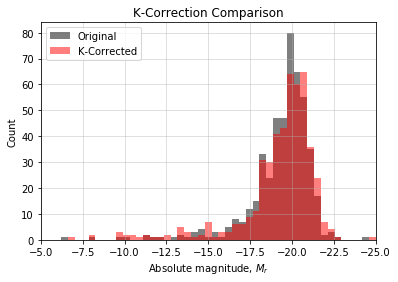

In [172]:
## MAKING COMPARISON HISTOGRAM
fig, ax = plt.subplots(1, 1)

    
ax.hist(OLD_scut_specTable['rerun_abs_mag'], bins = np.linspace(-25, -5, 50), color='black', alpha=0.5, label='Original')
ax.hist(kcorr_absmag['rabsmag'], bins = np.linspace(-25, -5, 50), color='red', alpha=0.5, label='K-Corrected')
ax.legend()
ax.set(xlabel = 'Absolute magnitude, $M_r$',
       ylabel = 'Count',
       title  = 'K-Correction Comparison')
ax.grid(alpha=0.5)
plt.xlim(-5,-25)

## Appending vflag

In [173]:
kcorr_absmag['vflag'] = -9

for i in range(len(master_table_cut)):
    SN_ID = master_table_cut['ID'][i]
    idx_bool = kcorr_absmag['ID'] == SN_ID
    kcorr_absmag['vflag'][idx_bool] = master_table_cut['vflag'][i]

In [174]:
KCAM_1 = kcorr_absmag['vflag'] != -9
kcorr_absmag = kcorr_absmag[KCAM_1]

KCAM_2 = kcorr_absmag['vflag'] != 9
kcorr_absmag = kcorr_absmag[KCAM_2]

KCAM_3 = kcorr_absmag['vflag'] != 2
kcorr_absmag = kcorr_absmag[KCAM_3]

In [175]:
kcorr_absmag

ID,redshift,petroMag_r,rabsmag,vflag
int32,float64,float64,float64,int32
1584,0.08,17.40083,-19.631426768273315,0
465,0.054,16.76493,-19.423829364519463,0
419,0.06227,16.42431,-20.05545917782679,1
48713,0.01697,13.93589,-19.773378136188466,1
736,0.073,17.55096,-19.258872944899753,0
1456,0.094,15.97771,-21.385874150488046,0
55449,0.035322,16.50294,-18.745529589593506,1
4568,0.05,16.91579,-19.07635869297333,1
52219,0.03013,16.05543,-18.86813363066817,0


## Rates!

### Mag Split

In [176]:
### Separating void/wall and magnitude.
k_vbool = kcorr_absmag['vflag'] == 1
k_wbool = kcorr_absmag['vflag'] == 0

kcorr_vSN = kcorr_absmag[k_vbool]
kcorr_wSN = kcorr_absmag[k_wbool]

# -- magnitude scale is backwards, these are correct
def k_mag_split(data_table):
   dwbool    = data_table['rabsmag']>-17
   brbool    = data_table['rabsmag']<-20
   bool17_18 = np.logical_and(data_table['rabsmag']<-17,data_table['rabsmag']>-18)
   bool18_19 = np.logical_and(data_table['rabsmag']<-18,data_table['rabsmag']>-19)
   bool19_20 = np.logical_and(data_table['rabsmag']<-19,data_table['rabsmag']>-20)
   bool17_18h = np.logical_and(data_table['rabsmag']<-17,data_table['rabsmag']>-18.5)
   bool18h_20 = np.logical_and(data_table['rabsmag']<-18.5,data_table['rabsmag']>-20)
   faint_bool    = data_table['rabsmag']>-15

   dwarf_table  = data_table[dwbool]
   bright_table = data_table[brbool]
   table17_18   = data_table[bool17_18]
   table18_19   = data_table[bool18_19]
   table19_20   = data_table[bool19_20]
   table17_18h = data_table[bool17_18h]
   table18h_20 = data_table[bool18h_20]
   faint_table = data_table[faint_bool]

   return dwarf_table, bright_table, table17_18, table18_19, table19_20, table17_18h, table18h_20, faint_table

In [177]:
Kvdwarf_table, Kvbright_table, Kv17_18table, Kv18_19table, Kv19_20table, Kv17_18hTable, Kv18h_20Table, Kv_faint_table = k_mag_split(kcorr_vSN)

Kwdwarf_table, Kwbright_table, Kwtable17_18, Kwtable18_19, Kwtable19_20, Kwtable17_18h, Kwtable18h_20, Kw_faint_table = k_mag_split(kcorr_wSN)

# mag_split(sn_table)

### Histograms

Ks_2sampResult(statistic=0.0, pvalue=1.0)


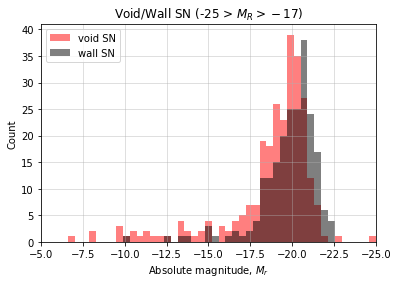

In [178]:
### Histogram of SN separated into void and wall of all M_r.
make_hist(kcorr_vSN['rabsmag'], kcorr_wSN['rabsmag'], np.linspace(-25, -5, 50))
plt.xlim(-5,-25)
plt.title('Void/Wall SN (-25 > $M_R > -17$)')
print(ks_2samp(kcorr_vSN['rabsmag'], kcorr_vSN['rabsmag']))

Ks_2sampResult(statistic=0.2863636363636364, pvalue=0.41204949719579304)
Anderson_ksampResult(statistic=-0.060592490224603585, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.37081375253536836)
N_wall = 11
N_void = 40


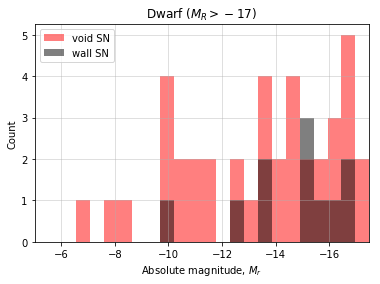

In [179]:
### DWARF ( > -17)
make_hist(Kvdwarf_table['rabsmag'], Kwdwarf_table['rabsmag'], np.linspace(-17.5, -5, 25))
plt.xlim(-5,-17.5)
plt.title('Dwarf ($M_R > -17$)')
print(ks_2samp(Kvdwarf_table['rabsmag'], Kwdwarf_table['rabsmag']))
print(anderson_ksamp([Kvdwarf_table['rabsmag'], Kwdwarf_table['rabsmag']]))
print('N_wall = {:d}'.format(len(Kwdwarf_table['rabsmag'])))
print('N_void = {:d}'.format(len(Kvdwarf_table['rabsmag'])))

Ks_2sampResult(statistic=0.2120300751879699, pvalue=0.5833774396466404)
Anderson_ksampResult(statistic=-0.5088767806741434, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.5949526048393117)
N_wall = 19
N_void = 35


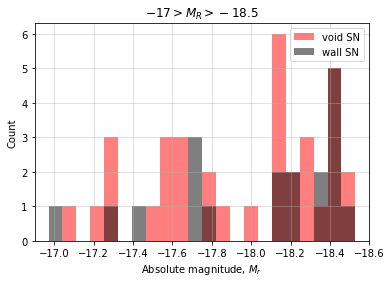

In [180]:
### 17-18.5

make_hist(Kv17_18hTable['rabsmag'], Kwtable17_18h['rabsmag'], np.linspace(-18.6, -16.9, 25))
plt.xlim(-16.9,-18.6)
plt.title('$-17 > M_R > -18.5$')
print(ks_2samp(Kv17_18hTable['rabsmag'], Kwtable17_18h['rabsmag']))
print(anderson_ksamp([Kv17_18hTable['rabsmag'], Kwtable17_18h['rabsmag']]))
print('N_wall = {:d}'.format(len(Kwtable17_18h['rabsmag'])))
print('N_void = {:d}'.format(len(Kv17_18hTable['rabsmag'])))

Ks_2sampResult(statistic=0.16958041958041958, pvalue=0.21089088567852)
Anderson_ksampResult(statistic=-0.39343379838579057, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.5262404088226719)
N_wall = 65
N_void = 88


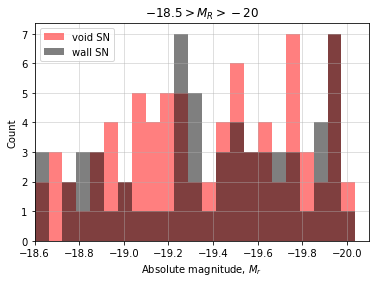

In [181]:
### 18.5-20

make_hist(Kv18h_20Table['rabsmag'], Kwtable18h_20['rabsmag'], np.linspace(-20.1, -18.6, 25))
plt.xlim(-18.6,-20.1)
plt.title('$-18.5 > M_R > -20$')
print(ks_2samp(Kv18h_20Table['rabsmag'], Kwtable18h_20['rabsmag']))
print(anderson_ksamp([Kv18h_20Table['rabsmag'], Kwtable18h_20['rabsmag']]))
print('N_wall = {:d}'.format(len(Kwtable18h_20['rabsmag'])))
print('N_void = {:d}'.format(len(Kv18h_20Table['rabsmag'])))

Ks_2sampResult(statistic=0.2876357154432021, pvalue=0.00015079201850887612)
Anderson_ksampResult(statistic=-1.3256755058485503, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=1.4452744836499827)
N_wall = 121
N_void = 102


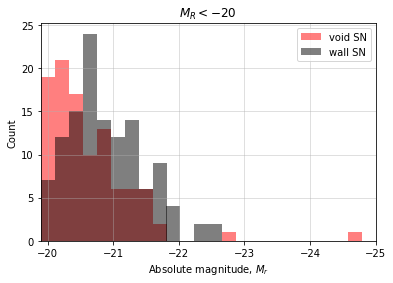

In [182]:
### BRIGHT (< -20)
make_hist(Kvbright_table['rabsmag'], Kwbright_table['rabsmag'], np.linspace(-25, -19.9, 25))
plt.xlim(-19.9,-25)
plt.title('$M_R < -20$')
print(ks_2samp(Kvbright_table['rabsmag'], Kwbright_table['rabsmag']))
print(anderson_ksamp([Kvbright_table['rabsmag'], Kvbright_table['rabsmag']]))
print('N_wall = {:d}'.format(len(Kwbright_table['rabsmag'])))
print('N_void = {:d}'.format(len(Kvbright_table['rabsmag'])))

### Diagnostic Plots

In [183]:
### Append ra and dec of SN
kcorr_absmag['ra'] = -999.
kcorr_absmag['dec'] = -999.

for i in range(len(master_table_cut)):
    SN_ID = master_table_cut['ID'][i]
    idx_bool = kcorr_absmag['ID'] == SN_ID
    kcorr_absmag['ra'][idx_bool] = master_table_cut['ra'][i]
    kcorr_absmag['dec'][idx_bool] = master_table_cut['dec'][i]

Text(0, 0.5, 'Dec')

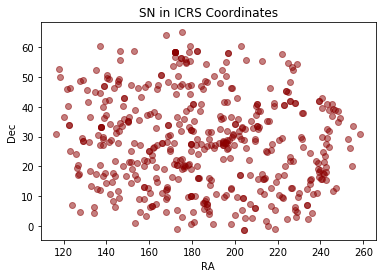

In [184]:
plt.scatter(kcorr_absmag['ra'], kcorr_absmag['dec'], color='darkred', alpha = 0.5)
plt.title('SN in ICRS Coordinates')
plt.xlabel('RA')
plt.ylabel('Dec')

In [185]:
## Will need to do mollweide on bluehive.
# kcorr_absmag.write('k_mollwCoords.txt', format='ascii.commented_header')

Text(0.5, 0, 'Redshift, z')

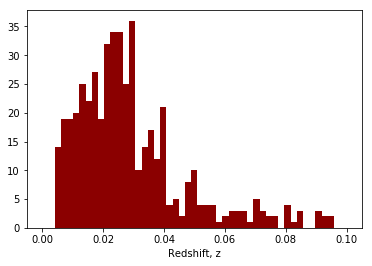

In [186]:
plt.hist(kcorr_absmag['redshift'], bins=np.linspace(0.0, 0.1, 50), color='darkred')
plt.xlabel('Redshift, z')

### Number of SN:

In [187]:
Kvoid_sn    =  float(np.sum(kcorr_vSN['vflag'] == 1))
Kwall_sn    =  float(np.sum(kcorr_wSN['vflag'] == 0))

KvDwarf_sn  =  float(np.sum(Kvdwarf_table['vflag'] == 1))
KwDwarf_sn  =  float(np.sum(Kwdwarf_table['vflag'] == 0))

Kv1718h_sn  =  float(np.sum(Kv17_18hTable['vflag'] == 1))
Kw1718h_sn  =  float(np.sum(Kwtable17_18h['vflag'] == 0))

Kv18h20_sn  =  float(np.sum(Kv18h_20Table['vflag'] == 1))
Kw18h20_sn  =  float(np.sum(Kwtable18h_20['vflag'] == 0))

KvBright_sn =  float(np.sum(Kvbright_table['vflag'] == 1))
KwBright_sn =  float(np.sum(Kwbright_table['vflag'] == 0))

In [188]:
Kvoid_rate    =  Kvoid_sn/void_gal
Kwall_rate    =  Kwall_sn/wall_gal

KvDwarf_rate  =  KvDwarf_sn/vDwarf_gal
KwDwarf_rate  =  KwDwarf_sn/wDwarf_gal

Kv1718h_rate  =  Kv1718h_sn/v1718h_gal
Kw1718h_rate  =  Kw1718h_sn/w1718h_gal

Kv18h20_rate  =  Kv18h20_sn/v18h20_gal
Kw18h20_rate  =  Kw18h20_sn/w18h20_gal

KvBright_rate =  KvBright_sn/vBright_gal
KwBright_rate =  KwBright_sn/wBright_gal

In [189]:
unc_Kvoid_rate    =  np.sqrt(Kvoid_sn)/void_gal
unc_Kwall_rate    =  np.sqrt(Kwall_sn)/wall_gal

unc_KvDwarf_rate  =  np.sqrt(KvDwarf_sn)/vDwarf_gal
unc_KwDwarf_rate  =  np.sqrt(KwDwarf_sn)/wDwarf_gal

unc_Kv1718h_rate  =  np.sqrt(Kv1718h_sn)/v1718h_gal
unc_Kw1718h_rate  =  np.sqrt(Kw1718h_sn)/w1718h_gal

unc_Kv18h20_rate  =  np.sqrt(Kv18h20_sn)/v18h20_gal
unc_Kw18h20_rate  =  np.sqrt(Kw18h20_sn)/w18h20_gal

unc_KvBright_rate =  np.sqrt(KvBright_sn)/vBright_gal
unc_KwBright_rate =  np.sqrt(KwBright_sn)/wBright_gal

In [190]:
print('Total Number of SN: ', len(kcorr_vSN)+len(kcorr_wSN))
print('-----------------------------------------------------------------------')
print('Void SN Rate: {:.5f}'.format(Kvoid_rate),', uncertainty: {:.6f}'.format(unc_Kvoid_rate), '       |  # void SN = {:d}'.format(len(kcorr_vSN['rabsmag'])))
print('Wall SN Rate: {:.5f}'.format(Kwall_rate),', uncertainty: {:.6f}'.format(unc_Kwall_rate), '       |  # wall SN = {:d}'.format(len(kcorr_wSN['rabsmag'])))
print('-----------------------------------------------------------------------')
print('Dwarf Void SN Rate: {:.5f}'.format(KvDwarf_rate),', uncertainty: {:.6f}'.format(unc_KvDwarf_rate), ' |  # void SN = {:d}'.format(len(Kvdwarf_table['rabsmag'])))
print('Dwarf Wall SN Rate: {:.5f}'.format(KwDwarf_rate),', uncertainty: {:.6f}'.format(unc_KwDwarf_rate), ' |  # wall SN = {:d}'.format(len(Kwdwarf_table['rabsmag'])))
print('-----------------------------------------------------------------------')
print('17-18h Void SN Rate: {:.5f}'.format(Kv1718h_rate),', uncertainty: {:.6f}'.format(unc_Kv1718h_rate), '|  # void SN = {:d}'.format(len(Kv17_18hTable['rabsmag'])))
print('17-18h Wall SN Rate: {:.5f}'.format(Kw1718h_rate),', uncertainty: {:.6f}'.format(unc_Kw1718h_rate), '|  # wall SN = {:d}'.format(len(Kwtable17_18h['rabsmag'])))
print('-----------------------------------------------------------------------')
print('18h-20 Void SN Rate: {:.5f}'.format(Kv18h20_rate),', uncertainty: {:.6f}'.format(unc_Kv18h20_rate), '|  # void SN = {:d}'.format(len(Kv18h_20Table['rabsmag'])))
print('18h-20 Wall SN Rate: {:.5f}'.format(Kw18h20_rate),', uncertainty: {:.6f}'.format(unc_Kw18h20_rate), '|  # wall SN = {:d}'.format(len(Kwtable18h_20['rabsmag'])))
print('-----------------------------------------------------------------------')
print('Bright Void SN Rate: {:.5f}'.format(KvBright_rate),', uncertainty: {:.6f}'.format(unc_KvBright_rate), '|  # void SN = {:d}'.format(len(Kvbright_table['rabsmag'])))
print('Bright Wall SN Rate: {:.5f}'.format(KwBright_rate),', uncertainty: {:.6f}'.format(unc_KwBright_rate), '|  # wall SN = {:d}'.format(len(Kwbright_table['rabsmag'])))
print('-----------------------------------------------------------------------')

Total Number of SN:  481
-----------------------------------------------------------------------
Void SN Rate: 0.00352 , uncertainty: 0.000216        |  # void SN = 265
Wall SN Rate: 0.00035 , uncertainty: 0.000024        |  # wall SN = 216
-----------------------------------------------------------------------
Dwarf Void SN Rate: 0.01360 , uncertainty: 0.002150  |  # void SN = 40
Dwarf Wall SN Rate: 0.00299 , uncertainty: 0.000901  |  # wall SN = 11
-----------------------------------------------------------------------
17-18h Void SN Rate: 0.00450 , uncertainty: 0.000760 |  # void SN = 35
17-18h Wall SN Rate: 0.00099 , uncertainty: 0.000228 |  # wall SN = 19
-----------------------------------------------------------------------
18h-20 Void SN Rate: 0.00666 , uncertainty: 0.000710 |  # void SN = 88
18h-20 Wall SN Rate: 0.00203 , uncertainty: 0.000251 |  # wall SN = 65
-----------------------------------------------------------------------
Bright Void SN Rate: 0.00199 , uncertainty: 0